In [427]:
from google.colab import drive

drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [428]:
#import Prophet for model building
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date

import holidays


In [429]:
#IMPORT DATA

#A_Data
access_a = pd.read_csv('/content/gdrive/Shared drives/IST 718 Project/a_ts_access.csv').drop(['Unnamed: 0'],axis=1)
software_a = pd.read_csv('/content/gdrive/Shared drives/IST 718 Project/a_ts_software.csv').drop(['Unnamed: 0'],axis=1)
application_a = pd.read_csv('/content/gdrive/Shared drives/IST 718 Project/a_ts_application.csv').drop(['Unnamed: 0'],axis=1)
general_a = pd.read_csv('/content/gdrive/Shared drives/IST 718 Project/a_ts_general.csv').drop(['Unnamed: 0'],axis=1)
email_a = pd.read_csv('/content/gdrive/Shared drives/IST 718 Project/a_ts_email.csv').drop(['Unnamed: 0'],axis=1)
hardware_a = pd.read_csv('/content/gdrive/Shared drives/IST 718 Project/a_ts_hardware.csv').drop(['Unnamed: 0'],axis=1)

#J_Data
task_j = pd.read_csv('/content/gdrive/Shared drives/IST 718 Project/j_ts_task.csv').drop(['Unnamed: 0'],axis=1)
desktop_laptop_j = pd.read_csv('/content/gdrive/Shared drives/IST 718 Project/j_ts_desktop.csv').drop(['Unnamed: 0'],axis=1)
access_pw_j = pd.read_csv('/content/gdrive/Shared drives/IST 718 Project/j_ts_access.csv').drop(['Unnamed: 0'],axis=1)
application_support_j = pd.read_csv('/content/gdrive/Shared drives/IST 718 Project/j_ts_application.csv').drop(['Unnamed: 0'],axis=1)
infrastructure_j = pd.read_csv('/content/gdrive/Shared drives/IST 718 Project/j_ts_infrastructure.csv').drop(['Unnamed: 0'],axis=1)
easy_connect_j = pd.read_csv('/content/gdrive/Shared drives/IST 718 Project/j_ts_connect.csv').drop(['Unnamed: 0'],axis=1)
tele_conference_j = pd.read_csv('/content/gdrive/Shared drives/IST 718 Project/j_ts_teleconference.csv').drop(['Unnamed: 0'],axis=1)

In [430]:
categories_a = ['access-issue/request', 'software', 'application-issue/request', 'general', 'email', 'computer hardware']
categories_j = ['Task','Desktop or laptop', 'Access and passwords', 'Application support', 'Infrastructure services', 'Easy connect', 'Telephone & Conference (Audio, Video)']

hourly_rate = 40

#get us holidays as df
us_holidays = pd.DataFrame()
hdates = []
hname = []
for date, name in sorted(holidays.US(years=2020).items()):
  hdates.append(date)
  hname.append(name)

us_holidays['ds'] = hdates
us_holidays['ds'] = pd.to_datetime(us_holidays['ds'], format = '%Y-%m-%d')
us_holidays['holiday'] = hname



### ESTABLISH FUNCTIONS

In [431]:
#WRITE FUNCTION 1
#----- df = df straight after import (before transformation)
#----- y_var = y variable. count or bdn_avg
#----- category = category tested (from categories list)
#----- time = number of days forecasted out. default 90 days

def get_forecast(df, y_var, category, time=90):
  #Data Transformation for Prophet
  df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
  df = df.set_index('date') #set index as date for subsetting
  
  #Split DF intro training set
  train_df = df[:'2020-09-30']
  train_df.reset_index(inplace=True)
  train_fbp = train_df.rename(columns = {'date': 'ds', y_var: 'y'}) #DF for count forecast

  #build models
  model = Prophet(holidays=us_holidays)
  model.fit(train_fbp) 
  #forecast models
  future = model.make_future_dataframe(periods=time, freq='D') #look ahead 90 days
  forecast = model.predict(future)

  print('----------------------------------------------------------------------------------------')
  print('TICKET {} FORECAST FOR CATEGORY: {}'.format(y_var, category))
  print('----------------------------------------------------------------------------------------')
  print('FORECAST TABLE:')
  print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
  print('----------------------------------------------------------------------------------------')
  # plot forecast
  fig = model.plot(forecast)
  ax = fig.gca()
  ax.set_title('{} Forecast'.format(y_var), size=18)
  a = add_changepoints_to_plot(fig.gca(), model, forecast)
  plt.show()
  fig2 = model.plot_components(forecast)
  plt.show()

  forecast_abv = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']] #grab just these columns
  return forecast_abv


In [432]:
#WRITE FUNCTION 2
#----- df = forecast df (df output following get_forecast)

def negative_to_zero_transform(df):
  df_tmp = df[['yhat', 'yhat_lower', 'yhat_upper']]
  df_date = df[['ds']]
  #df_tmp[df_tmp < 0] = 0
  df_tmp['date'] = df_date
  df_output = df_tmp
  return df_output


In [433]:
#WRITE FUNCTION 3
#run third
#----- df1 = fbdn df
#----- df2 = fcount df
def get_staffing(df1, df2, category):
  #Convert to Staffing Schedule
  staffing = pd.DataFrame()
  staffing['date'] = df1['date']
  staffing['lower_est'] = ((df1['yhat_lower']*df2['yhat_lower']/60/60)/8).astype(float) #lower estimate (in hours)
  staffing['est'] = ((df1['yhat']*df2['yhat']/60/60)/8).astype(float) #estimate (in hours
  staffing['upper_est'] = ((df1['yhat_upper']*df2['yhat_upper']/60/60)/8).astype(float) #upper estimate (in hours)
  staffing

  return staffing

In [434]:
#WRITE FUNCTION 4
#-- get costs for staffing
#----- df = df output from get_staffing
def get_cost(df, category):
  hourly_rate = 40
  #get cost df
  cost_df = pd.DataFrame()
  cost_df['date'] = df['date']
  cost_df['lower_cost_est'] = df['lower_est']*hourly_rate
  cost_df['mid_cost_est'] = df['est']*hourly_rate
  cost_df['upper_cost_est'] = df['upper_est']*hourly_rate

  #Transform to Long Form
  df = cost_df.set_index('date')
  new_df = df.unstack().reset_index()
  new_df.columns = ['Category', 'Date', 'Value']
  new_df = new_df[['Date', 'Value', 'Category']]
  new_df

  #Plot Data
  fig, ax = plt.subplots(figsize=(18,8))
  sns.lineplot(ax=ax, data=new_df, x='Date', y='Value', hue='Category', err_style="bars", ci=68).set_title('Predicted Cost for Category: {}'.format(category))
  return cost_df

  

## A_DATA: ACCESS-ISSUE/REQUEST

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


----------------------------------------------------------------------------------------
TICKET count FORECAST FOR CATEGORY: access-issue/request
----------------------------------------------------------------------------------------
FORECAST TABLE:
            ds        yhat  yhat_lower  yhat_upper
268 2020-12-25  195.919151  158.851234  233.069195
269 2020-12-26   91.554555   51.777074  132.917745
270 2020-12-27  112.493108   70.980563  152.422656
271 2020-12-28  293.781482  254.211342  333.806607
272 2020-12-29  259.411970  223.591321  300.504016
----------------------------------------------------------------------------------------


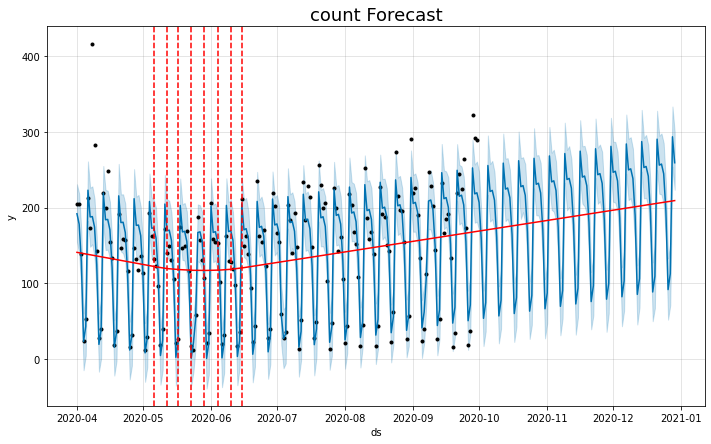

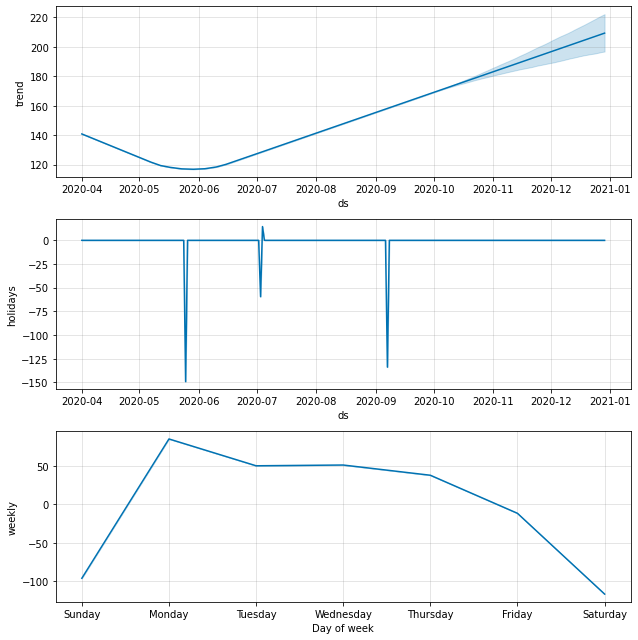

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


.
.
.
.
.
.
.
.
.
.
----------------------------------------------------------------------------------------
TICKET adj_bdn FORECAST FOR CATEGORY: access-issue/request
----------------------------------------------------------------------------------------
FORECAST TABLE:
            ds         yhat   yhat_lower   yhat_upper
268 2020-12-25  3891.200620  1437.168306  6228.452892
269 2020-12-26  2896.912823   355.888538  5396.320420
270 2020-12-27  2629.237367   267.307358  5016.411838
271 2020-12-28  4130.769577  1769.946681  6448.810517
272 2020-12-29  4067.023213  1516.977861  6487.545782
----------------------------------------------------------------------------------------


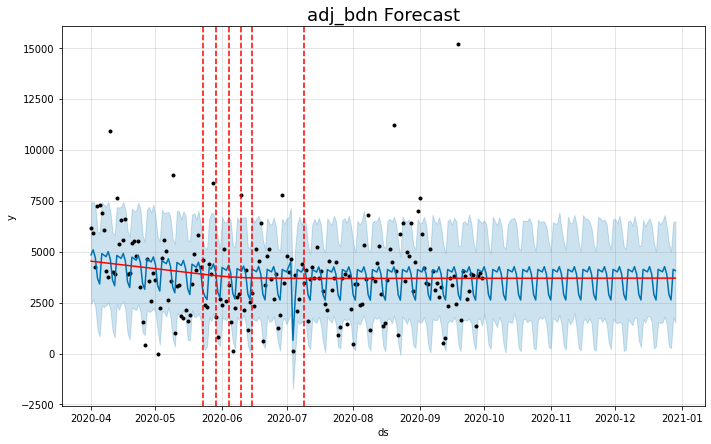

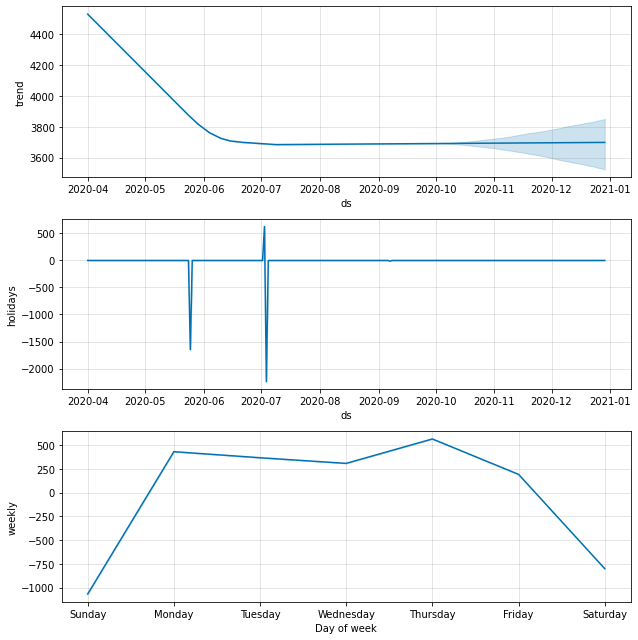

In [435]:
#GET FORECASTS
a_fcount = get_forecast(access_a, 'count', categories_a[0])
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
a_fbdn = get_forecast(access_a, 'adj_bdn', categories_a[0])

In [436]:
#remove 0s from DFs
a_fcount = negative_to_zero_transform(a_fcount)
a_fbdn = negative_to_zero_transform(a_fbdn)


date  lower_est        est  upper_est
0   2020-04-01  13.096281  32.245848  59.209905
1   2020-04-02  12.883319  31.443394  56.563548
2   2020-04-03   7.134084  20.910945  42.330898
3   2020-04-04  -0.632724   2.926531  12.490841
4   2020-04-05   0.123160   5.067646  16.948644
..         ...        ...        ...        ...
268 2020-12-25   7.926943  26.470858  50.404879
269 2020-12-26   0.639822   9.209221  24.905095
270 2020-12-27   0.658806  10.269829  26.549126
271 2020-12-28  15.622935  42.136931  74.744985
272 2020-12-29  11.777190  36.633142  67.692138

[273 rows x 4 columns]

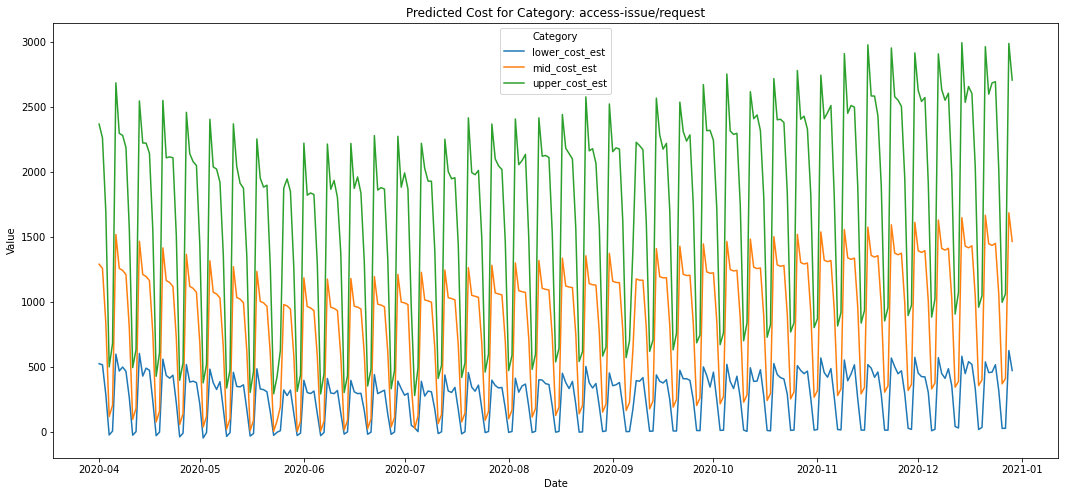

In [437]:
#GET STAFFING SCHEDULE
access_a_staffing = get_staffing(a_fbdn, a_fcount, categories_a[0])
access_a_cost = get_cost(access_a_staffing, categories_a[0])
access_a_staffing


## A_DATA: SOFTWARE

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


----------------------------------------------------------------------------------------
TICKET count FORECAST FOR CATEGORY: software
----------------------------------------------------------------------------------------
FORECAST TABLE:
            ds       yhat  yhat_lower  yhat_upper
268 2020-12-25  50.821720   35.334102   66.614247
269 2020-12-26  -5.282801  -21.565923   11.028517
270 2020-12-27  -0.301371  -16.318786   15.335028
271 2020-12-28  82.290949   67.005477   99.176594
272 2020-12-29  79.257089   65.655953   95.247027
----------------------------------------------------------------------------------------


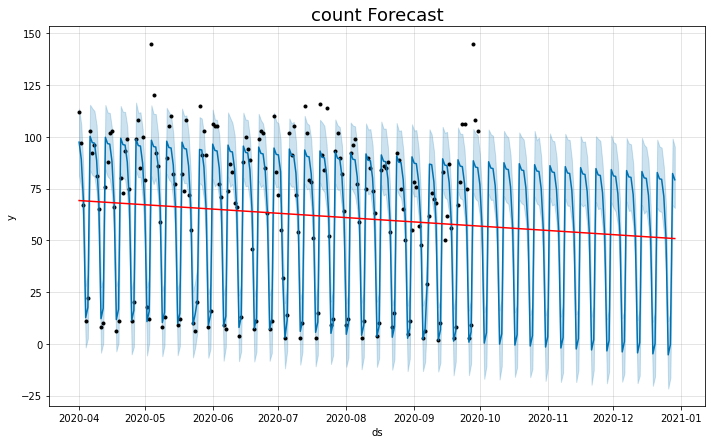

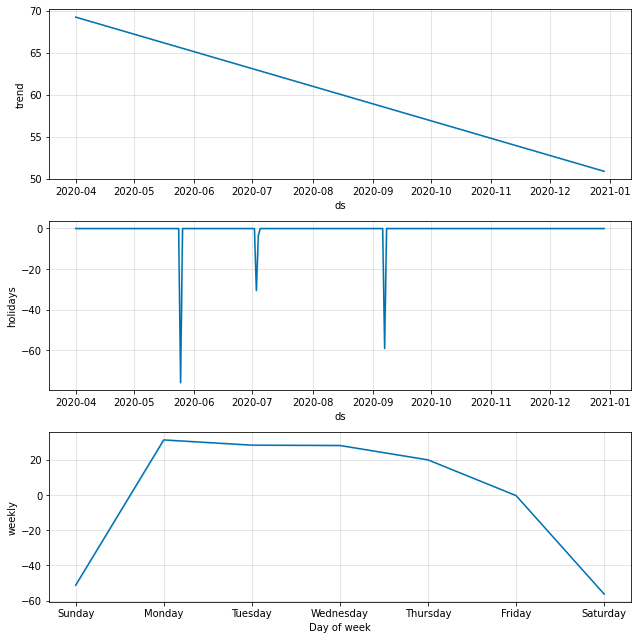

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


.
.
.
.
.
.
.
.
.
.
----------------------------------------------------------------------------------------
TICKET adj_bdn FORECAST FOR CATEGORY: software
----------------------------------------------------------------------------------------
FORECAST TABLE:
            ds         yhat   yhat_lower   yhat_upper
268 2020-12-25  3165.249127  -263.149685  6461.945982
269 2020-12-26  1095.679573 -2288.987208  4352.872211
270 2020-12-27  2584.377684  -799.207808  5838.985368
271 2020-12-28  3390.127966  -108.630597  6957.724566
272 2020-12-29  3149.891226  -511.928268  6251.857732
----------------------------------------------------------------------------------------


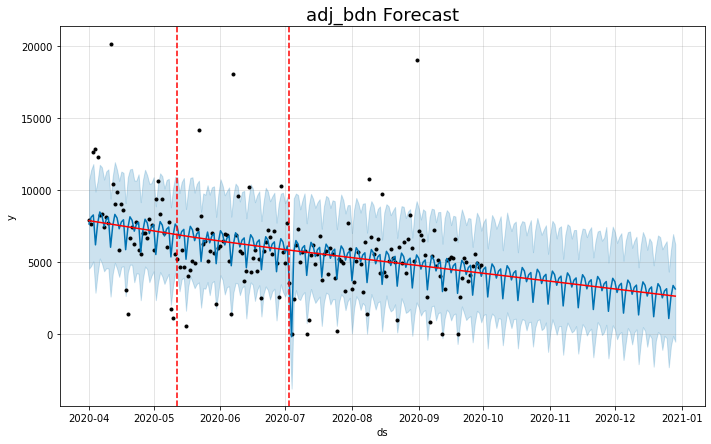

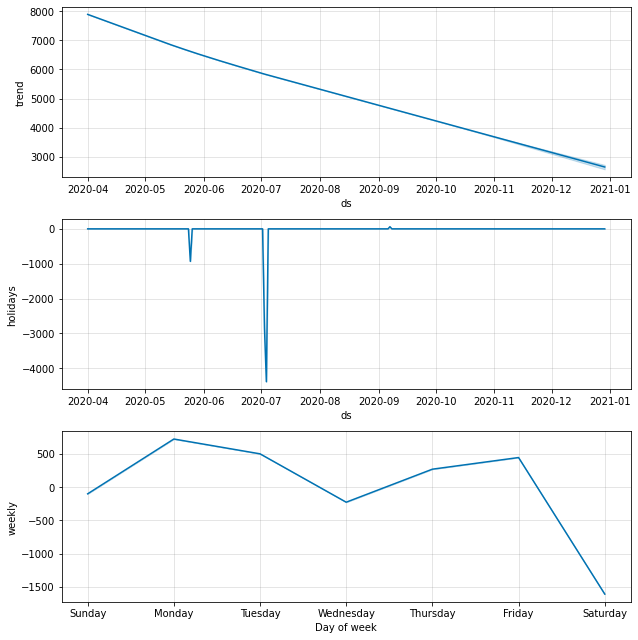

In [438]:
#GET FORECASTS
a_fcount = get_forecast(software_a, 'count', categories_a[1])
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
a_fbdn = get_forecast(software_a, 'adj_bdn', categories_a[1])


In [439]:
#remove 0s from DFs
a_fcount = negative_to_zero_transform(a_fcount)
a_fbdn = negative_to_zero_transform(a_fbdn)


date  lower_est        est  upper_est
0   2020-04-01  12.835382  25.914903  42.208696
1   2020-04-02  12.368024  25.182406  41.867214
2   2020-04-03   9.177701  19.782655  34.306288
3   2020-04-04  -0.170411   2.731578   9.644004
4   2020-04-05   0.381712   4.714172  12.464613
..         ...        ...        ...        ...
268 2020-12-25  -0.322853   5.585535  14.946447
269 2020-12-26   1.714032  -0.200981   1.666865
270 2020-12-27   0.452851  -0.027044   3.109063
271 2020-12-28  -0.252738   9.686696  23.959841
272 2020-12-29  -1.167053   8.668445  20.676072

[273 rows x 4 columns]

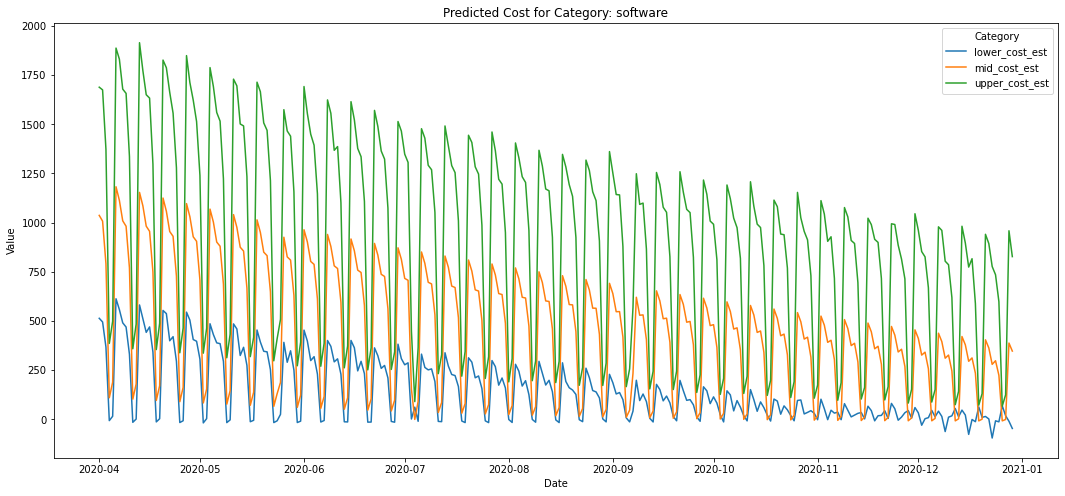

In [440]:
#GET STAFFING SCHEDULE
software_a_staffing = get_staffing(a_fbdn, a_fcount, categories_a[1])
software_a_cost = get_cost(software_a_staffing, categories_a[1])
software_a_staffing


## A_DATA: APPLICATION-ISSUE/REQUEST

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


----------------------------------------------------------------------------------------
TICKET count FORECAST FOR CATEGORY: application-issue/request
----------------------------------------------------------------------------------------
FORECAST TABLE:
            ds        yhat  yhat_lower  yhat_upper
268 2020-12-25  157.828802  130.494213  185.903380
269 2020-12-26  114.909349   89.501496  143.419577
270 2020-12-27  119.926597   93.816684  148.761818
271 2020-12-28  168.300072  140.067711  196.304066
272 2020-12-29  167.917022  139.322820  195.271809
----------------------------------------------------------------------------------------


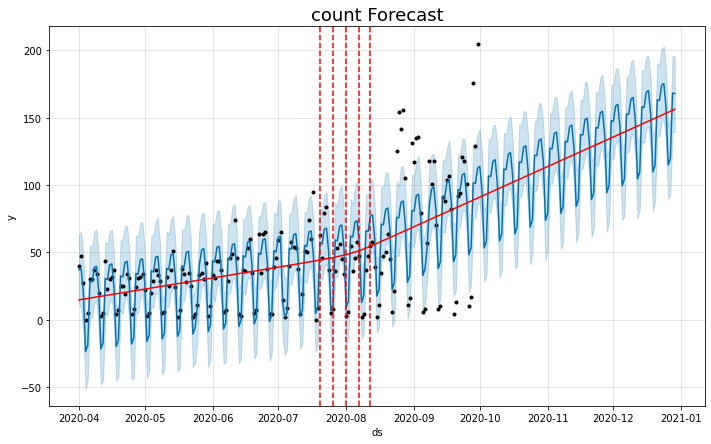

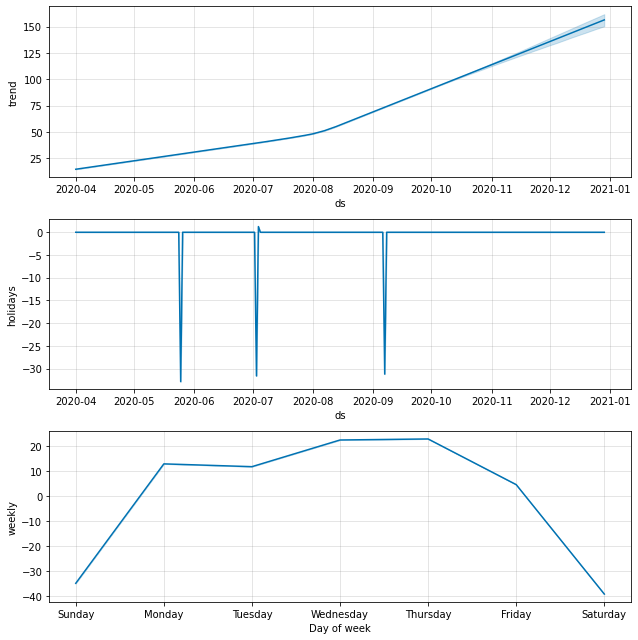

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


.
.
.
.
.
.
.
.
.
.
----------------------------------------------------------------------------------------
TICKET adj_bdn FORECAST FOR CATEGORY: application-issue/request
----------------------------------------------------------------------------------------
FORECAST TABLE:
            ds         yhat   yhat_lower   yhat_upper
268 2020-12-25  2278.717657  -281.465565  4915.819723
269 2020-12-26  -384.943337 -2828.019490  2305.404267
270 2020-12-27  1547.368457 -1058.637469  4102.755871
271 2020-12-28  1860.940210  -694.428543  4555.417522
272 2020-12-29  1478.675060 -1085.691457  4093.201273
----------------------------------------------------------------------------------------


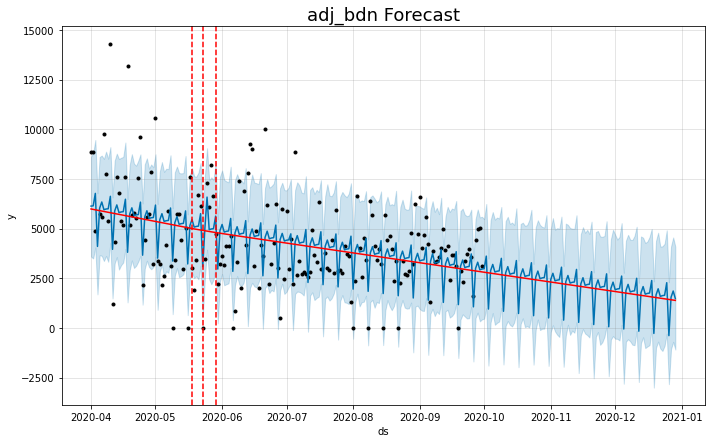

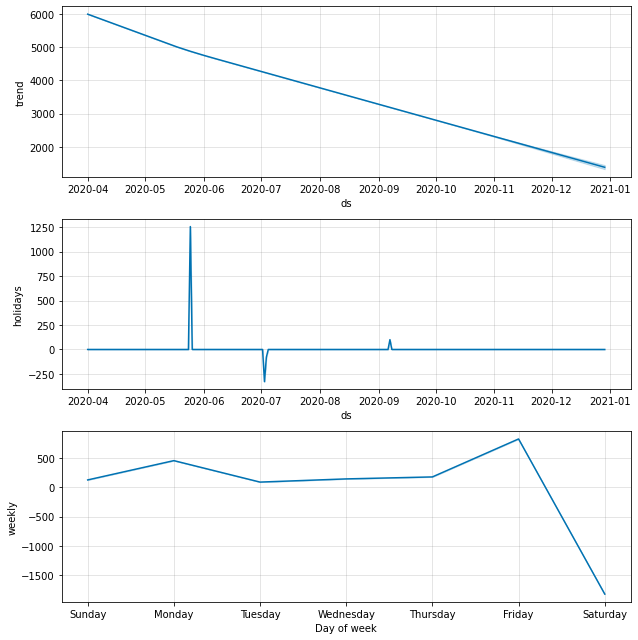

In [441]:
#GET FORECASTS
a_fcount = get_forecast(application_a, 'count', categories_a[2])
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
a_fbdn = get_forecast(application_a, 'adj_bdn', categories_a[2])

In [442]:
#remove 0s from DFs
a_fcount = negative_to_zero_transform(a_fcount)
a_fbdn = negative_to_zero_transform(a_fbdn)


date  lower_est        est  upper_est
0   2020-04-01   1.495432   7.899073  18.945836
1   2020-04-02   1.069341   8.060433  19.944721
2   2020-04-03  -1.265496   4.662166  15.745573
3   2020-04-04  -2.999134  -3.357287   0.614318
4   2020-04-05  -5.765453  -3.980832   2.462215
..         ...        ...        ...        ...
268 2020-12-25  -1.275334  12.487753  31.731510
269 2020-12-26  -8.788610  -1.535888  11.480559
270 2020-12-27  -3.448537   6.443425  21.192133
271 2020-12-28  -3.377327  10.874874  31.050242
272 2020-12-29  -5.252139   8.621344  27.753015

[273 rows x 4 columns]

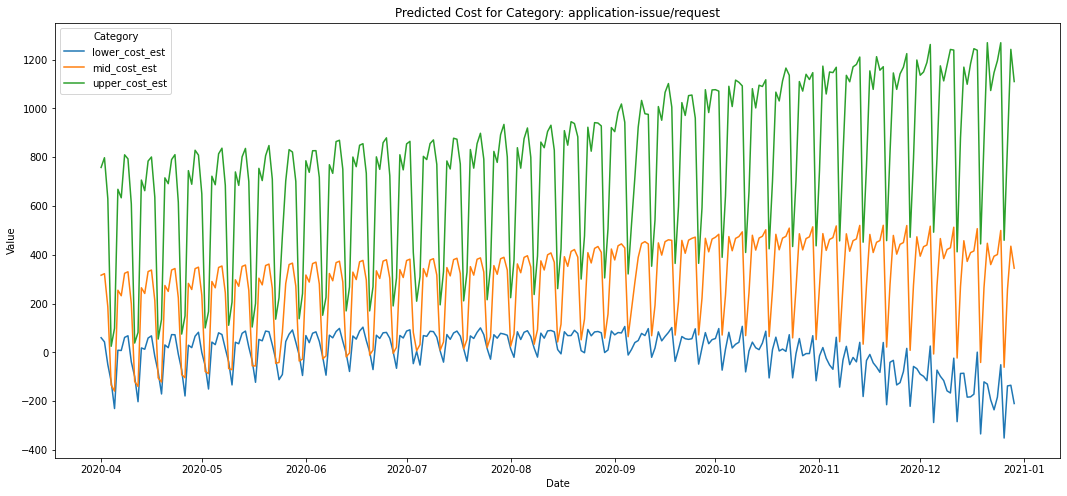

In [443]:
#GET STAFFING SCHEDULE
application_a_staffing = get_staffing(a_fbdn, a_fcount, categories_a[2])
application_a_cost = get_cost(application_a_staffing, categories_a[2])
application_a_staffing



## A_DATA: GENERAL

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


----------------------------------------------------------------------------------------
TICKET count FORECAST FOR CATEGORY: general
----------------------------------------------------------------------------------------
FORECAST TABLE:
            ds       yhat  yhat_lower  yhat_upper
268 2020-12-25  20.008692   13.282281   26.083744
269 2020-12-26   8.904259    2.847885   15.243707
270 2020-12-27   9.981147    3.102677   16.776336
271 2020-12-28  24.795483   17.968587   31.047749
272 2020-12-29  24.026168   17.983775   30.532122
----------------------------------------------------------------------------------------


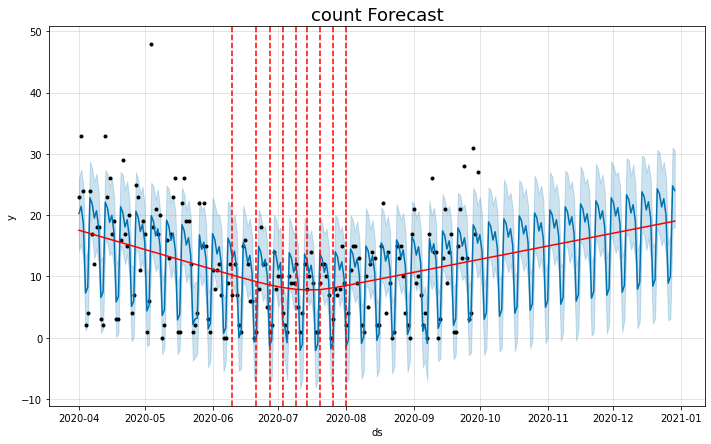

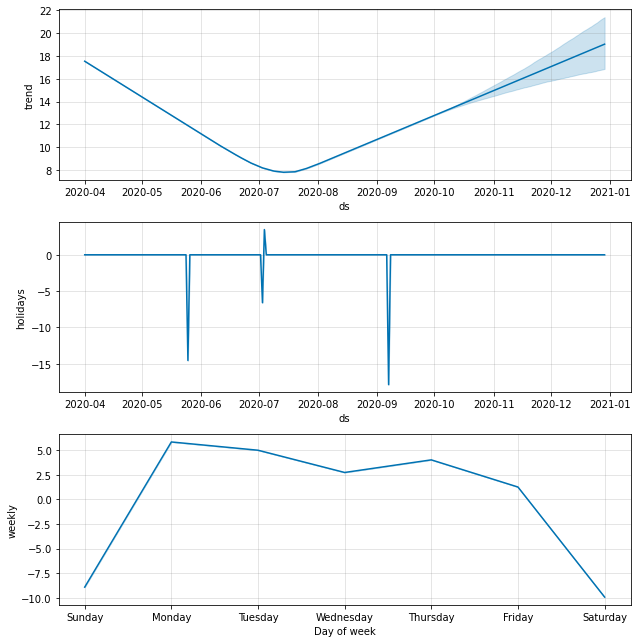

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


.
.
.
.
.
.
.
.
.
.
----------------------------------------------------------------------------------------
TICKET adj_bdn FORECAST FOR CATEGORY: general
----------------------------------------------------------------------------------------
FORECAST TABLE:
            ds         yhat    yhat_lower   yhat_upper
268 2020-12-25   516.599112  -9261.485967  9325.448935
269 2020-12-26 -4932.310186 -14224.282078  3834.125254
270 2020-12-27 -1727.021488 -10436.320175  7892.968555
271 2020-12-28 -2605.354065 -13046.759088  7308.802791
272 2020-12-29 -2809.502304 -12905.468495  6883.766214
----------------------------------------------------------------------------------------


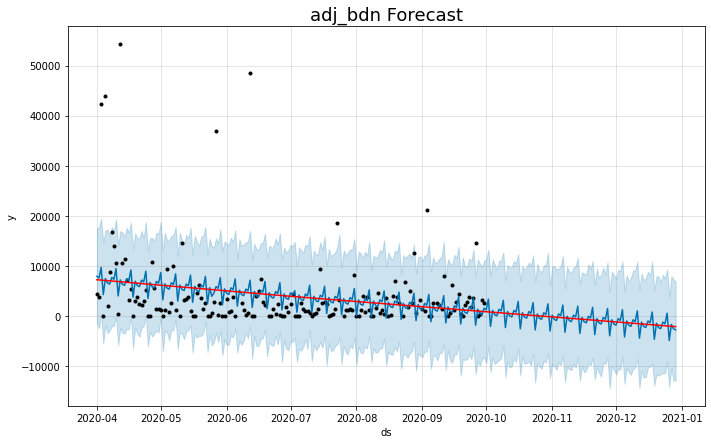

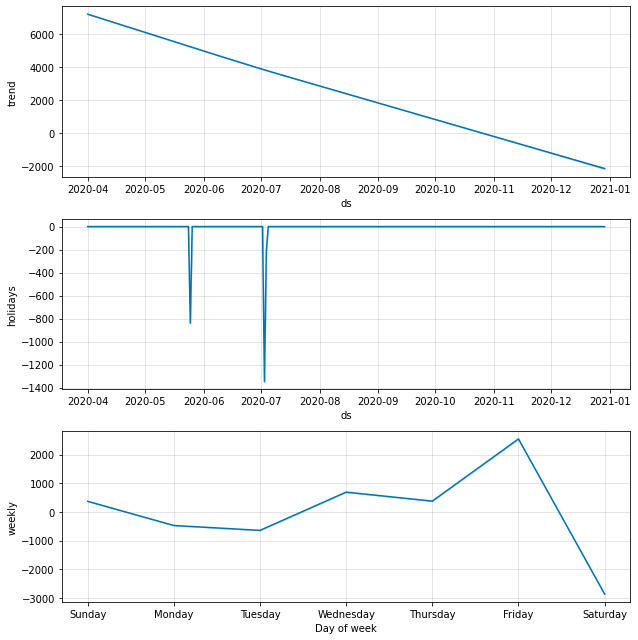

In [444]:
#GET FORECASTS
a_fcount = get_forecast(general_a, 'count', categories_a[3])
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
a_fbdn = get_forecast(general_a, 'adj_bdn', categories_a[3])

In [445]:
#remove 0s from DFs
a_fcount = negative_to_zero_transform(a_fcount)
a_fbdn = negative_to_zero_transform(a_fbdn)


date  lower_est       est  upper_est
0   2020-04-01  -0.713449  5.556328  15.900137
1   2020-04-02  -1.320283  5.617959  16.773115
2   2020-04-03   0.199770  6.245255  16.617666
3   2020-04-04  -0.233268  1.071955   6.588399
4   2020-04-05  -0.132029  2.116940   8.432291
..         ...        ...       ...        ...
268 2020-12-25  -4.271308  0.358905   8.445924
269 2020-12-26  -1.406567 -1.524950   2.029385
270 2020-12-27  -1.124324 -0.598530   4.597746
271 2020-12-28  -8.139994 -2.243091   7.879232
272 2020-12-29  -8.058647 -2.343805   7.297778

[273 rows x 4 columns]

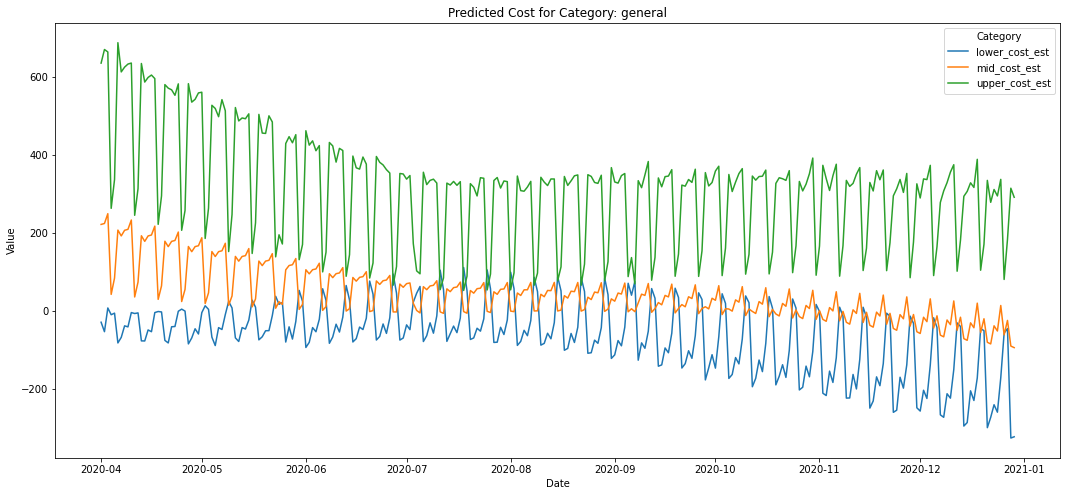

In [446]:
#GET STAFFING SCHEDULE
general_a_staffing = get_staffing(a_fbdn, a_fcount, categories_a[3])
general_a_cost = get_cost(general_a_staffing, categories_a[3])
general_a_staffing



## A_DATA: EMAIL

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


----------------------------------------------------------------------------------------
TICKET count FORECAST FOR CATEGORY: email
----------------------------------------------------------------------------------------
FORECAST TABLE:
            ds       yhat  yhat_lower  yhat_upper
268 2020-12-25  12.781435    7.713766   17.953042
269 2020-12-26   1.384458   -3.843225    6.489640
270 2020-12-27   3.569039   -1.089944    8.160992
271 2020-12-28  23.325486   18.563179   28.405685
272 2020-12-29  17.413708   12.563301   22.431028
----------------------------------------------------------------------------------------


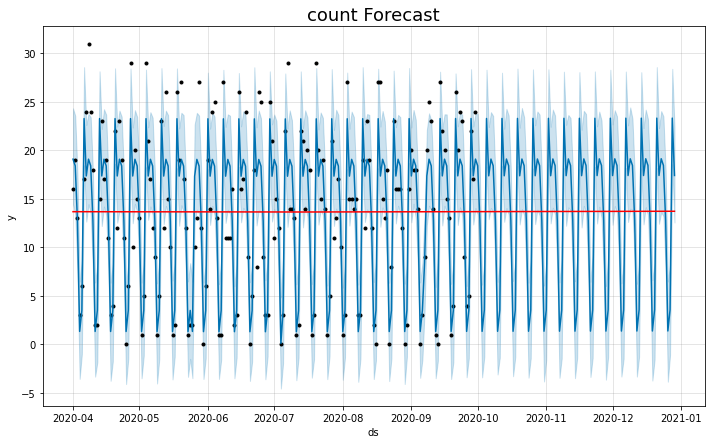

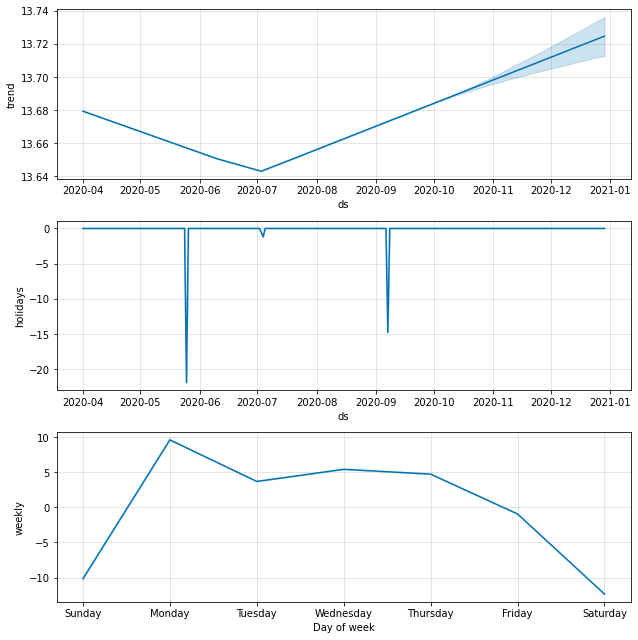

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


.
.
.
.
.
.
.
.
.
.
----------------------------------------------------------------------------------------
TICKET adj_bdn FORECAST FOR CATEGORY: email
----------------------------------------------------------------------------------------
FORECAST TABLE:
            ds        yhat   yhat_lower   yhat_upper
268 2020-12-25  912.261600 -7474.323224  8434.938740
269 2020-12-26 -966.371899 -8811.120749  6665.332381
270 2020-12-27  729.176625 -6961.689828  8261.020162
271 2020-12-28  853.402426 -6713.479802  8923.066725
272 2020-12-29  761.494439 -6958.489942  9118.921066
----------------------------------------------------------------------------------------


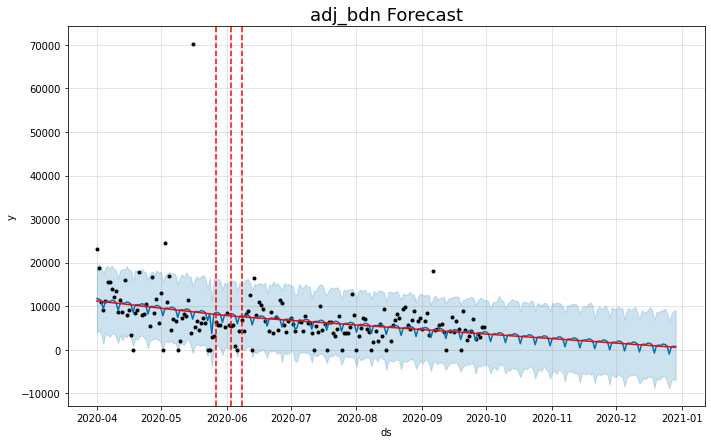

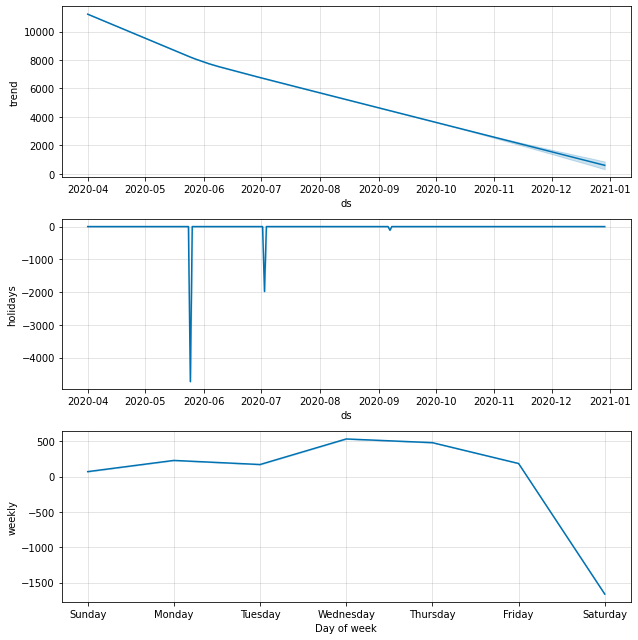

In [447]:
#GET FORECASTS
a_fcount = get_forecast(email_a, 'count', categories_a[4])
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
a_fbdn = get_forecast(email_a, 'adj_bdn', categories_a[4])

In [448]:
#remove 0s from DFs
a_fcount = negative_to_zero_transform(a_fcount)
a_fbdn = negative_to_zero_transform(a_fbdn)


date  lower_est       est  upper_est
0   2020-04-01   1.950002  7.798281  16.178997
1   2020-04-02   2.095231  7.447994  15.955122
2   2020-04-03   0.974628  4.998832  11.644008
3   2020-04-04  -0.168287  0.437249   3.921975
4   2020-04-05  -0.129757  1.354881   5.649109
..         ...        ...       ...        ...
268 2020-12-25  -2.001916  0.404862   5.258084
269 2020-12-26   1.175803 -0.046455   1.501931
270 2020-12-27   0.263467  0.090363   2.340907
271 2020-12-28  -4.327206  0.691181   8.800897
272 2020-12-29  -3.035472  0.460432   7.102319

[273 rows x 4 columns]

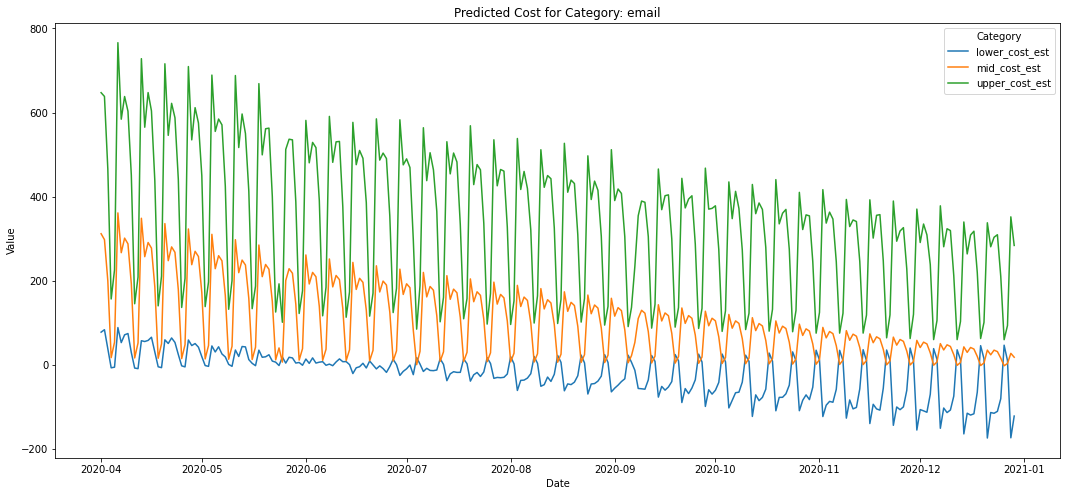

In [449]:
#GET STAFFING SCHEDULE
email_a_staffing = get_staffing(a_fbdn, a_fcount, categories_a[4])
email_a_cost = get_cost(email_a_staffing, categories_a[4])
email_a_staffing



## A_DATA: COMPUTER HARDWARE

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


----------------------------------------------------------------------------------------
TICKET count FORECAST FOR CATEGORY: computer hardware
----------------------------------------------------------------------------------------
FORECAST TABLE:
            ds       yhat  yhat_lower  yhat_upper
268 2020-12-25  20.903864   15.174958   26.415080
269 2020-12-26   7.205131    1.375737   12.708435
270 2020-12-27   7.314309    1.702835   12.807524
271 2020-12-28  30.483869   24.994052   36.415853
272 2020-12-29  26.004491   20.569288   31.897934
----------------------------------------------------------------------------------------


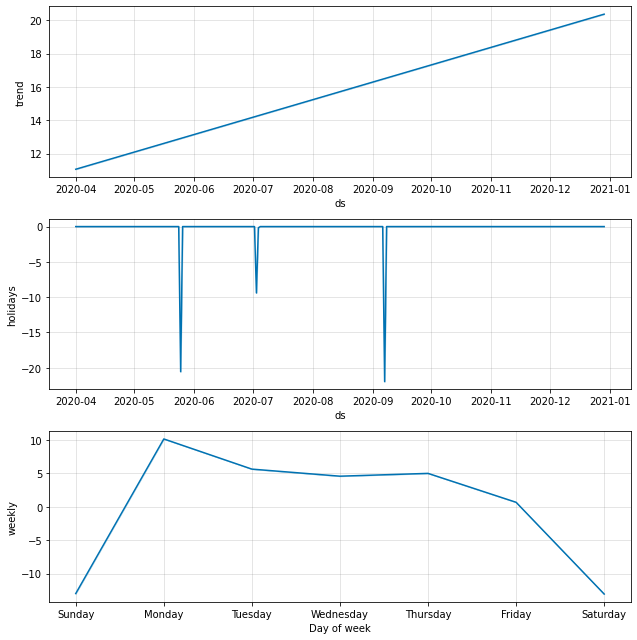

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


.
.
.
.
.
.
.
.
.
.
----------------------------------------------------------------------------------------
TICKET adj_bdn FORECAST FOR CATEGORY: computer hardware
----------------------------------------------------------------------------------------
FORECAST TABLE:
            ds          yhat   yhat_lower    yhat_upper
268 2020-12-25  10231.248455     8.565697  20210.659672
269 2020-12-26  12050.555968  2076.620499  22417.558489
270 2020-12-27   9829.140164   466.884221  19408.930345
271 2020-12-28   9989.712085  -322.909721  19965.169278
272 2020-12-29   9365.344810 -1023.110503  19289.562942
----------------------------------------------------------------------------------------


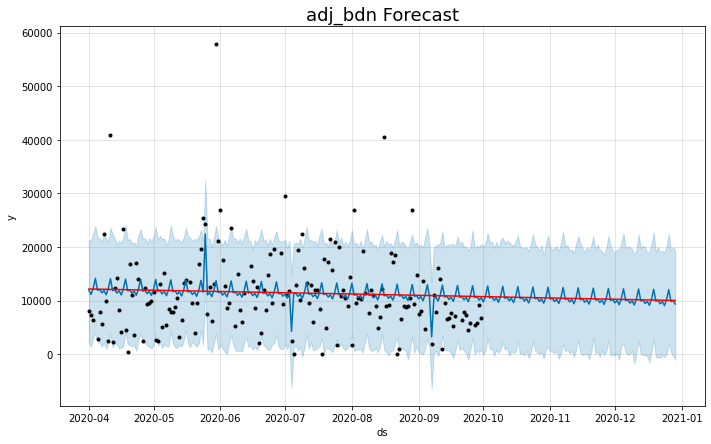

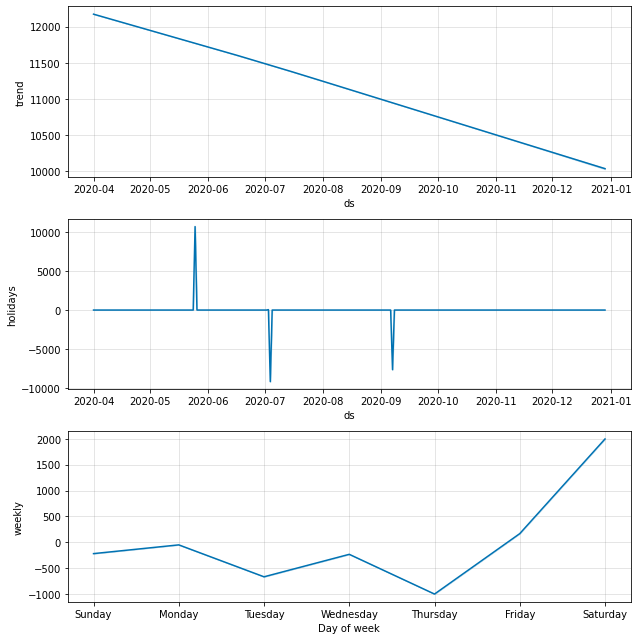

In [450]:
#GET FORECASTS
a_fcount = get_forecast(hardware_a, 'count', categories_a[5])
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
a_fbdn = get_forecast(hardware_a, 'adj_bdn', categories_a[5])

In [451]:
#remove 0s from DFs
a_fcount = negative_to_zero_transform(a_fcount)
a_fbdn = negative_to_zero_transform(a_fbdn)


date  lower_est        est  upper_est
0   2020-04-01   0.771866   6.482875  15.318477
1   2020-04-02   0.521767   6.238645  16.111252
2   2020-04-03   0.742514   5.049469  13.604131
3   2020-04-04  -1.010135  -0.933775   2.772239
4   2020-04-05  -0.621787  -0.741975   3.029277
..         ...        ...        ...        ...
268 2020-12-25   0.004513   7.426133  18.537021
269 2020-12-26   0.099197   3.014786   9.892086
270 2020-12-27   0.027605   2.496298   8.631262
271 2020-12-28  -0.280237  10.573787  25.244746
272 2020-12-29  -0.730717   8.456285  21.364486

[273 rows x 4 columns]

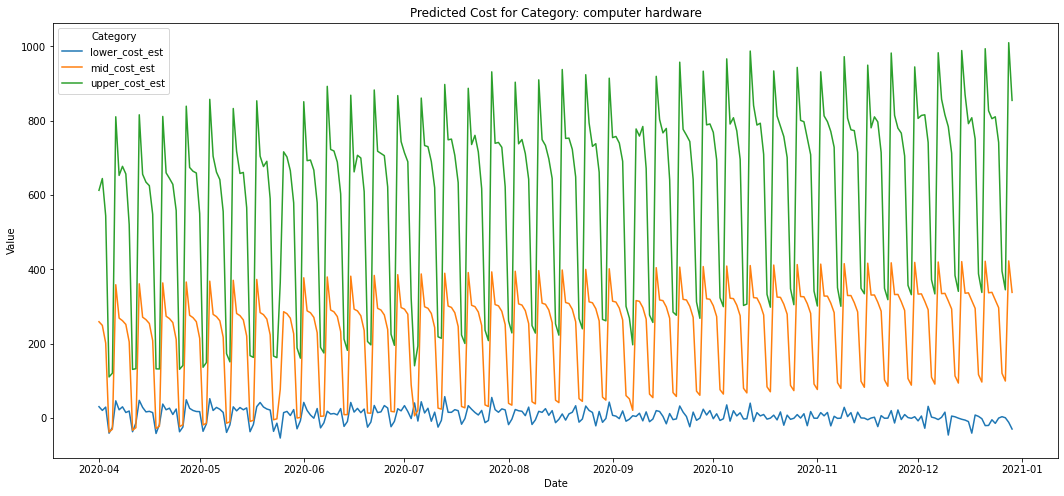

In [452]:
#GET STAFFING SCHEDULE
hardware_a_staffing = get_staffing(a_fbdn, a_fcount, categories_a[5])
hardware_a_cost = get_cost(hardware_a_staffing, categories_a[5])
hardware_a_staffing



## J_DATA: TASK

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


----------------------------------------------------------------------------------------
TICKET count FORECAST FOR CATEGORY: Task
----------------------------------------------------------------------------------------
FORECAST TABLE:
            ds       yhat  yhat_lower  yhat_upper
268 2020-12-25  27.760073   12.416144   45.481071
269 2020-12-26  21.143054    3.953373   37.622609
270 2020-12-27  19.186107    2.228587   35.175328
271 2020-12-28  31.694606   14.787383   48.028394
272 2020-12-29  32.970092   16.928541   49.885332
----------------------------------------------------------------------------------------


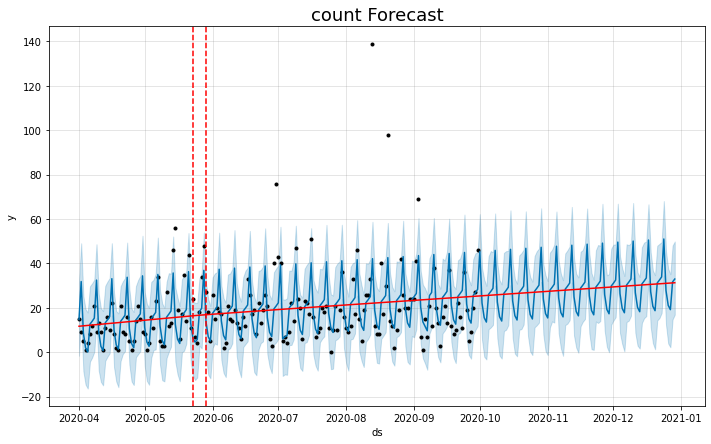

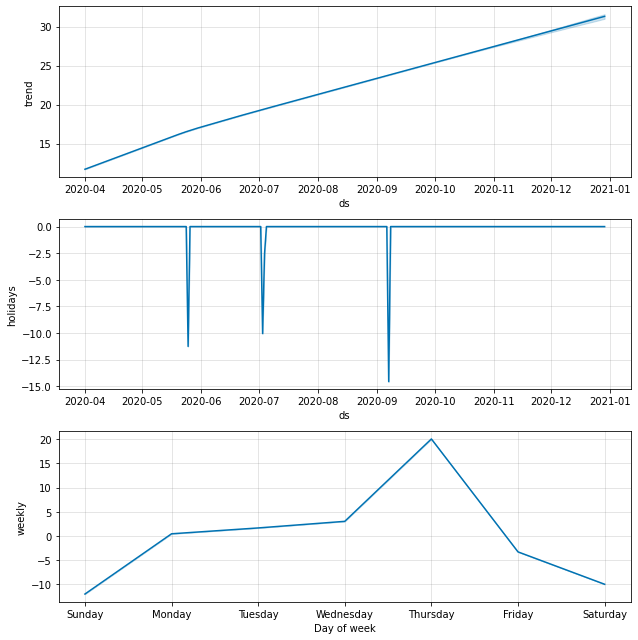

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


.
.
.
.
.
.
.
.
.
.
----------------------------------------------------------------------------------------
TICKET adj_bdn FORECAST FOR CATEGORY: Task
----------------------------------------------------------------------------------------
FORECAST TABLE:
            ds          yhat     yhat_lower    yhat_upper
268 2020-12-25 -36906.161668 -109014.551143  38892.261325
269 2020-12-26 -57808.247102 -122941.931821  12114.966214
270 2020-12-27 -35541.240702 -101066.236208  29238.798373
271 2020-12-28  10401.280404  -59300.138880  80254.067917
272 2020-12-29 -29225.168720  -99705.287169  40660.123542
----------------------------------------------------------------------------------------


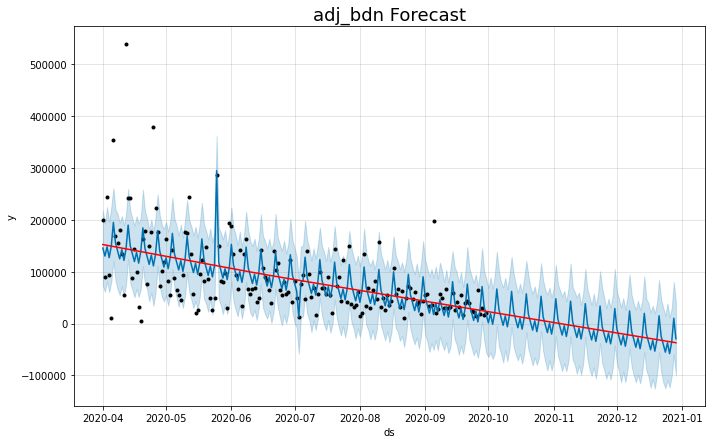

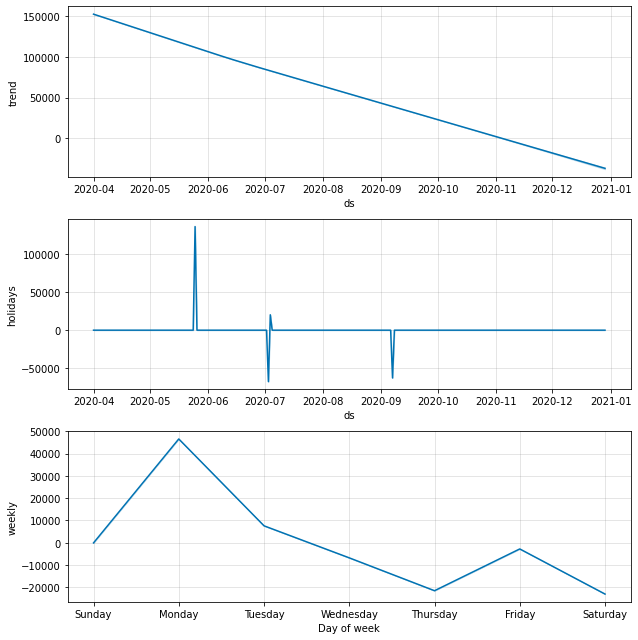

In [453]:
#GET FORECASTS
a_fcount = get_forecast(task_j, 'count', categories_j[0])
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
a_fbdn = get_forecast(task_j, 'adj_bdn', categories_j[0])

In [454]:
#remove 0s from DFs
a_fcount = negative_to_zero_transform(a_fcount)
a_fbdn = negative_to_zero_transform(a_fbdn)


date  lower_est         est   upper_est
0   2020-04-01  -3.989925   74.623397  239.986565
1   2020-04-02  32.551998  144.047997  329.843209
2   2020-04-03 -24.300373   44.382485  197.783497
3   2020-04-04 -30.637500    8.973878  131.843542
4   2020-04-05 -45.779677    0.513951  139.903313
..         ...        ...         ...         ...
268 2020-12-25 -46.997930  -35.573533   61.418809
269 2020-12-26 -16.876226  -42.438988   15.826272
270 2020-12-27  -7.820658  -23.677016   35.711261
271 2020-12-28 -30.447704   11.446684  133.835902
272 2020-12-29 -58.606427  -33.456823   70.428603

[273 rows x 4 columns]

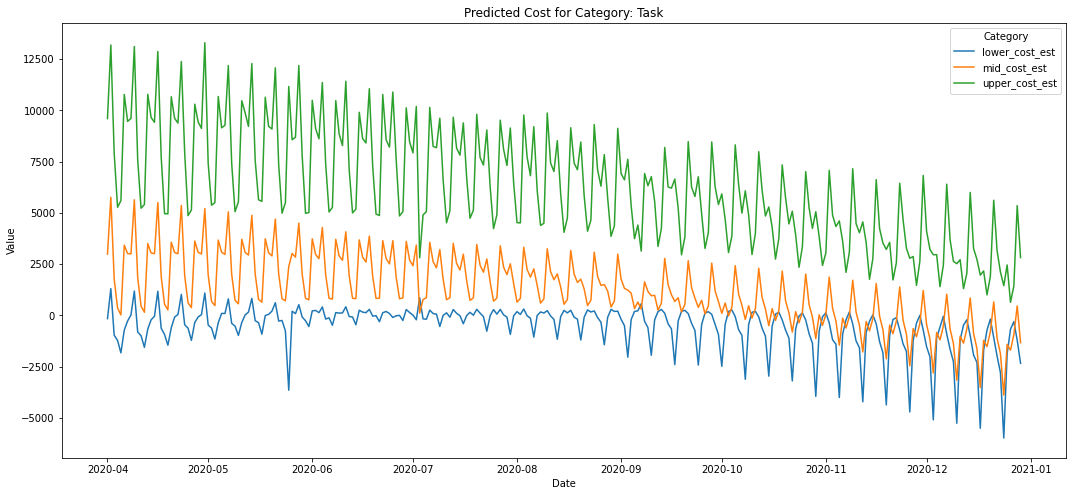

In [455]:
#GET STAFFING SCHEDULE
task_j_staffing = get_staffing(a_fbdn, a_fcount, categories_j[0])
task_j_cost = get_cost(task_j_staffing, categories_j[0])
task_j_staffing



## J_DATA: DESKTOP OR LAPTOP

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


----------------------------------------------------------------------------------------
TICKET count FORECAST FOR CATEGORY: Desktop or laptop
----------------------------------------------------------------------------------------
FORECAST TABLE:
            ds       yhat  yhat_lower  yhat_upper
268 2020-12-25  11.005364    7.084469   14.883788
269 2020-12-26   3.103535   -0.791637    7.021648
270 2020-12-27   4.169167    0.160897    7.987114
271 2020-12-28  14.704499   10.473136   18.361768
272 2020-12-29  13.592167    9.841259   17.605225
----------------------------------------------------------------------------------------


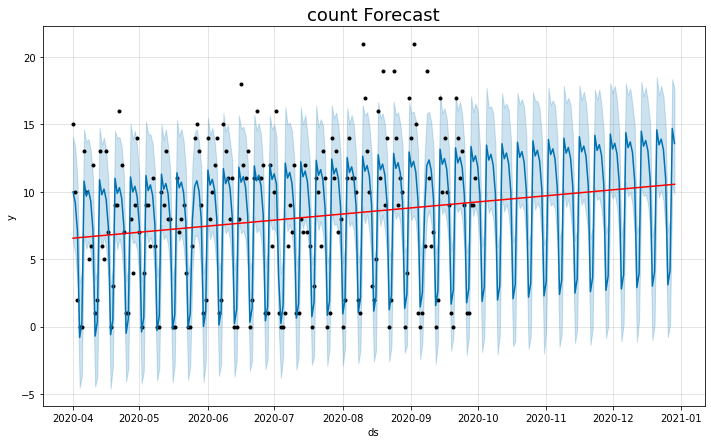

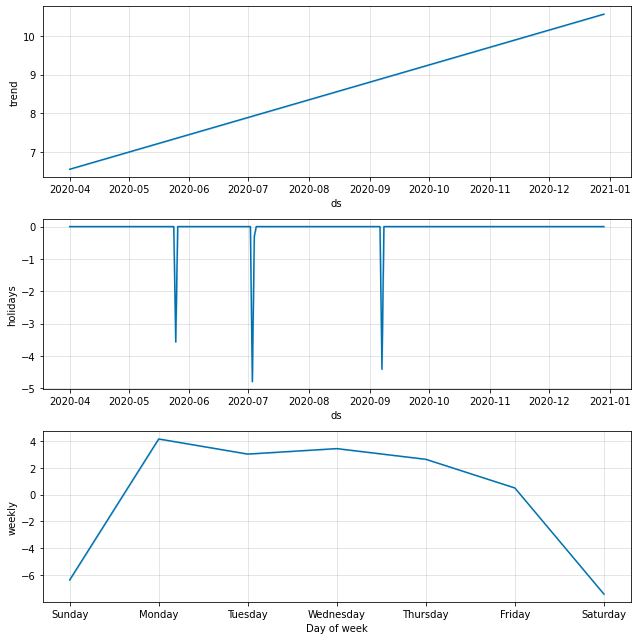

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


.
.
.
.
.
.
.
.
.
.
----------------------------------------------------------------------------------------
TICKET adj_bdn FORECAST FOR CATEGORY: Desktop or laptop
----------------------------------------------------------------------------------------
FORECAST TABLE:
            ds          yhat    yhat_lower    yhat_upper
268 2020-12-25  45251.672150  24723.404033  67353.237694
269 2020-12-26  34516.686758  12386.413907  56303.301340
270 2020-12-27  35992.372754  13034.360138  57617.172325
271 2020-12-28  46947.806852  24444.744359  70292.513457
272 2020-12-29  37581.438887  15377.100645  60078.929708
----------------------------------------------------------------------------------------


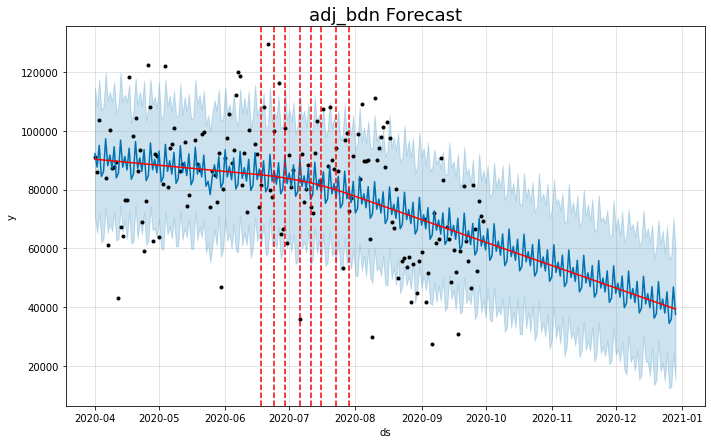

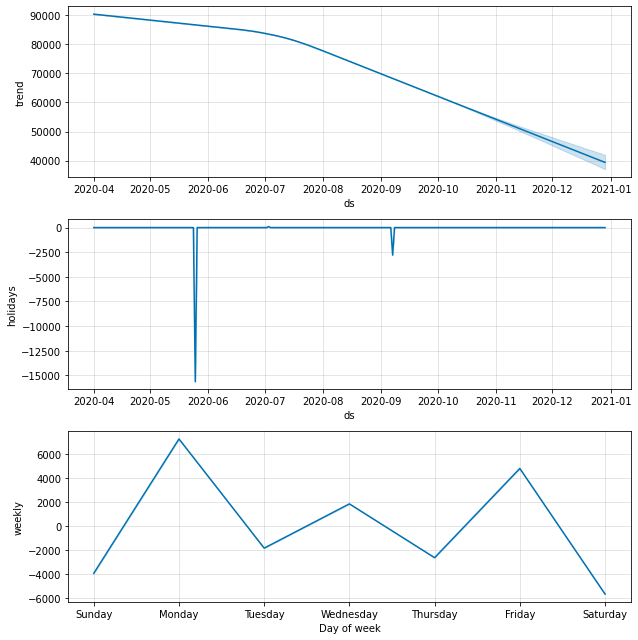

In [456]:
#GET FORECASTS
a_fcount = get_forecast(desktop_laptop_j, 'count', categories_j[1])
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
a_fbdn = get_forecast(desktop_laptop_j, 'adj_bdn', categories_j[1])

In [457]:
#remove 0s from DFs
a_fcount = negative_to_zero_transform(a_fcount)
a_fbdn = negative_to_zero_transform(a_fbdn)


date  lower_est        est  upper_est
0   2020-04-01  15.554544  32.018639  56.157958
1   2020-04-02  12.368436  28.054631  50.148982
2   2020-04-03   8.099770  23.408240  44.529963
3   2020-04-04  -9.784402  -2.365944  11.866303
4   2020-04-05  -8.074606   0.774465  15.504991
..         ...        ...        ...        ...
268 2020-12-25   6.081673  17.292053  34.808032
269 2020-12-26  -0.340470   3.719575  13.727151
270 2020-12-27   0.072819   5.210354  15.978990
271 2020-12-28   8.889345  23.970277  44.815792
272 2020-12-29   5.254515  17.736569  36.725802

[273 rows x 4 columns]

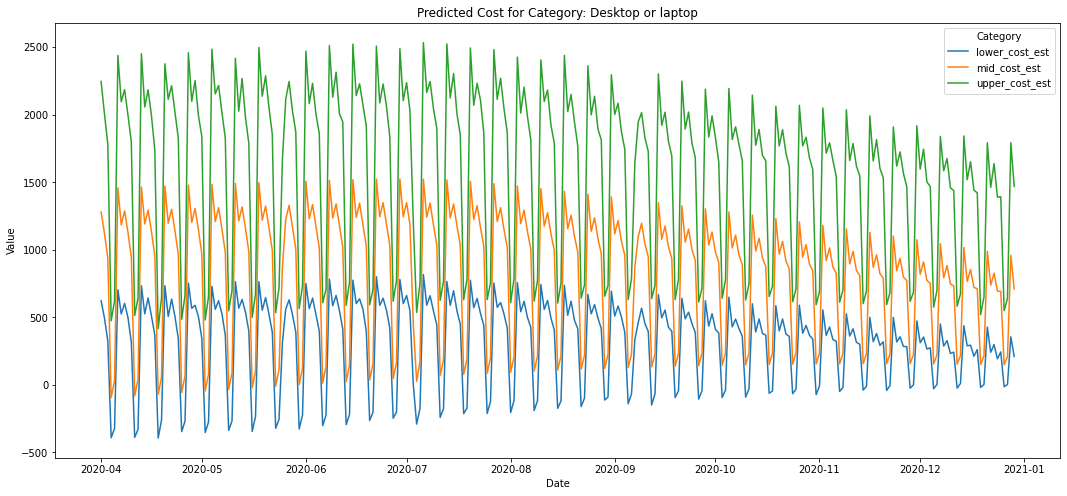

In [458]:
#GET STAFFING SCHEDULE
desktop_laptop_j_staffing = get_staffing(a_fbdn, a_fcount, categories_j[1])
desktop_laptop_j_cost = get_cost(desktop_laptop_j_staffing, categories_j[1])
desktop_laptop_j_staffing


## J_DATA: ACCESS AND PASSWORDS

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


----------------------------------------------------------------------------------------
TICKET count FORECAST FOR CATEGORY: Access and passwords
----------------------------------------------------------------------------------------
FORECAST TABLE:
            ds       yhat  yhat_lower  yhat_upper
268 2020-12-25   9.203362    4.056619   14.306369
269 2020-12-26   3.689200   -1.574143    8.605739
270 2020-12-27   4.502160   -0.409048    9.727282
271 2020-12-28  13.356806    8.447353   18.687786
272 2020-12-29  11.154530    6.302494   16.399461
----------------------------------------------------------------------------------------


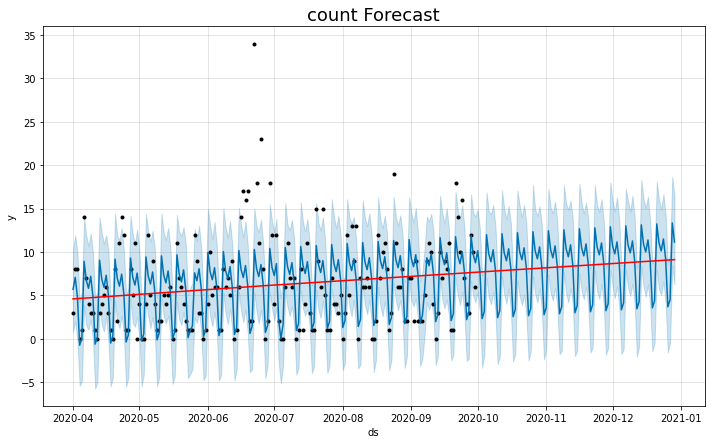

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


.
.
.
.
.
.
.
.
.
.
----------------------------------------------------------------------------------------
TICKET adj_bdn FORECAST FOR CATEGORY: Access and passwords
----------------------------------------------------------------------------------------
FORECAST TABLE:
            ds          yhat    yhat_lower    yhat_upper
268 2020-12-25  42703.698603  17159.328084  68680.121640
269 2020-12-26  40644.756957  12678.859241  66341.609646
270 2020-12-27  57233.379609  31297.866039  83507.958835
271 2020-12-28  39038.505533  12006.301103  63832.881640
272 2020-12-29  41382.639274  14607.738950  67851.592395
----------------------------------------------------------------------------------------


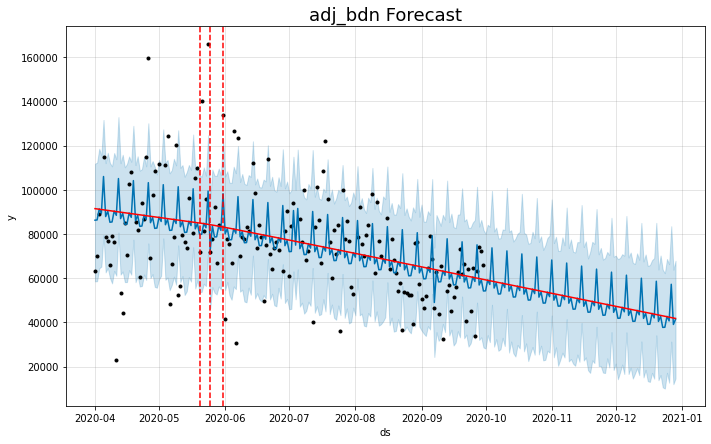

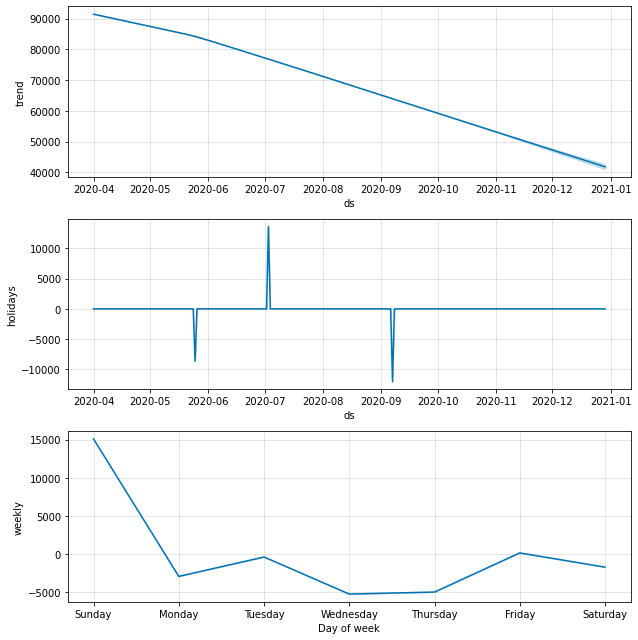

In [459]:
#GET FORECASTS
a_fcount = get_forecast(access_pw_j, 'count', categories_j[2])
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
a_fbdn = get_forecast(access_pw_j, 'adj_bdn', categories_j[2])

In [460]:
#remove 0s from DFs
a_fcount = negative_to_zero_transform(a_fcount)
a_fbdn = negative_to_zero_transform(a_fbdn)


date  lower_est        est  upper_est
0   2020-04-01   1.606669  17.068247  40.287174
1   2020-04-02   4.134279  21.226390  46.357575
2   2020-04-03  -0.529576  15.158469  40.699574
3   2020-04-04 -12.224848  -2.276951  17.145622
4   2020-04-05 -13.495866   0.296796  24.549922
..         ...        ...        ...        ...
268 2020-12-25   2.416974  13.646444  34.116776
269 2020-12-26  -0.692998   5.206481  19.823561
270 2020-12-27  -0.444525   8.947008  28.205051
271 2020-12-28   3.521579  18.105200  41.419974
272 2020-12-29   3.196708  16.027912  38.636443

[273 rows x 4 columns]

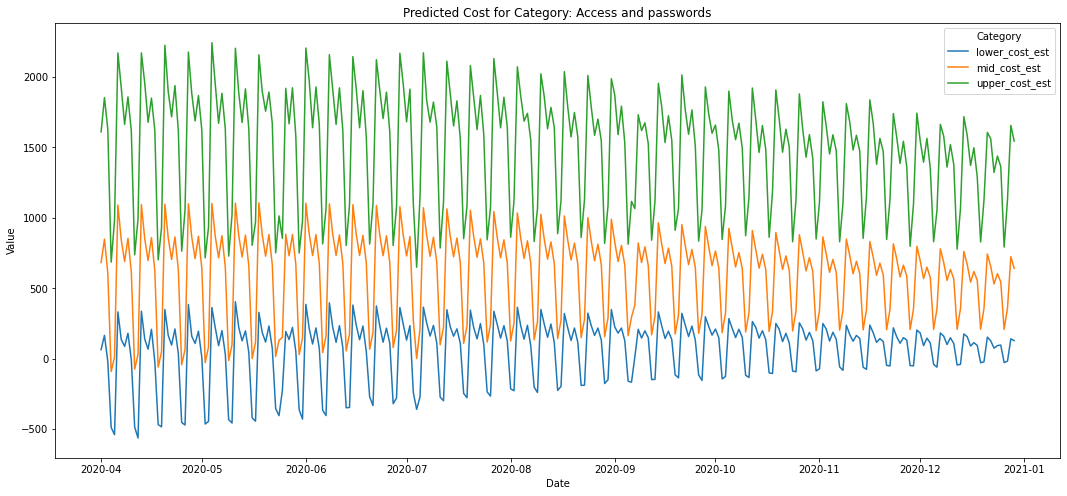

In [461]:
#GET STAFFING SCHEDULE
access_pw_j_staffing = get_staffing(a_fbdn, a_fcount, categories_j[2])
access_pw_j_cost = get_cost(access_pw_j_staffing, categories_j[2])
access_pw_j_staffing


## J_DATA: APPLICATION SUPPORT

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


----------------------------------------------------------------------------------------
TICKET count FORECAST FOR CATEGORY: Application support
----------------------------------------------------------------------------------------
FORECAST TABLE:
            ds      yhat  yhat_lower  yhat_upper
268 2020-12-25  6.705580    3.048556   10.254848
269 2020-12-26  2.027050   -1.282163    5.662285
270 2020-12-27  2.390460   -1.027238    5.784237
271 2020-12-28  9.377448    6.085545   12.639943
272 2020-12-29  9.040715    5.506105   12.285108
----------------------------------------------------------------------------------------


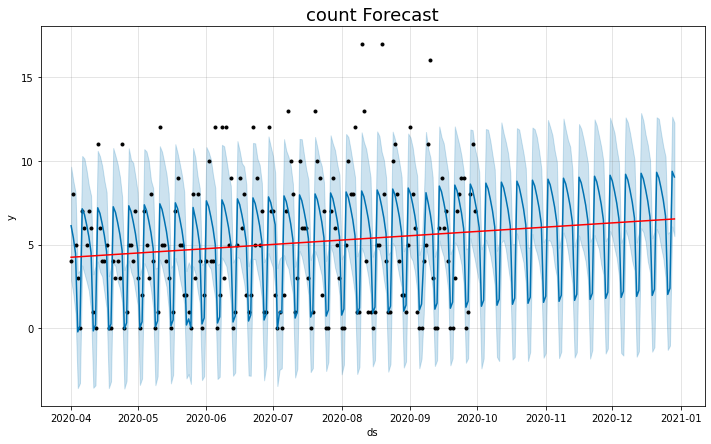

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


.
.
.
.
.
.
.
.
.
.
----------------------------------------------------------------------------------------
TICKET adj_bdn FORECAST FOR CATEGORY: Application support
----------------------------------------------------------------------------------------
FORECAST TABLE:
            ds          yhat    yhat_lower    yhat_upper
268 2020-12-25  39040.878307  11996.865600  67287.796990
269 2020-12-26  57281.692755  29459.742074  85816.826975
270 2020-12-27  51703.822972  22961.178140  79704.920201
271 2020-12-28  55269.373566  29782.655144  83565.964639
272 2020-12-29  51038.326779  22555.236789  80571.038337
----------------------------------------------------------------------------------------


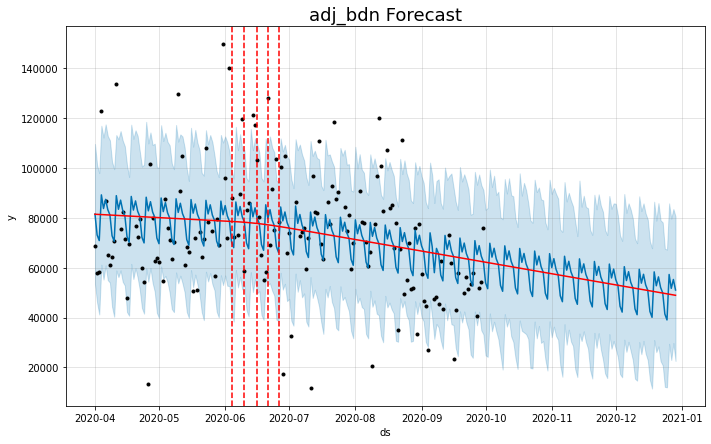

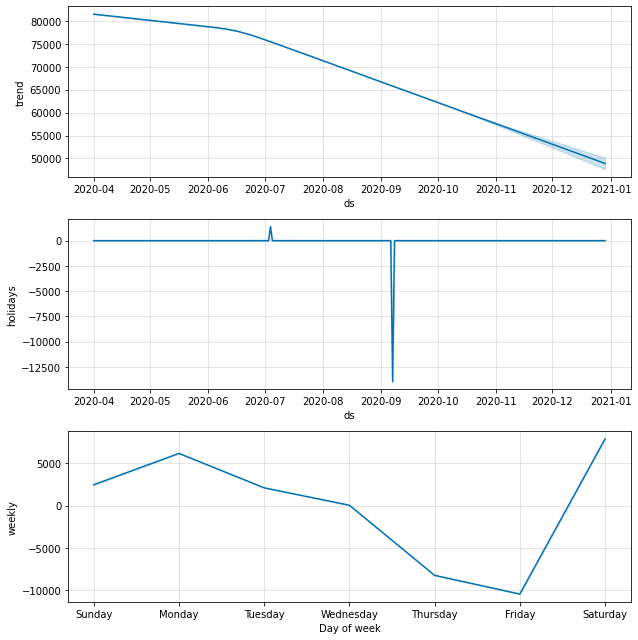

In [462]:
#GET FORECASTS
a_fcount = get_forecast(application_support_j, 'count', categories_j[3])
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
a_fbdn = get_forecast(application_support_j, 'adj_bdn', categories_j[3])

In [463]:
#remove 0s from DFs
a_fcount = negative_to_zero_transform(a_fcount)
a_fbdn = negative_to_zero_transform(a_fbdn)


date  lower_est        est  upper_est
0   2020-04-01   5.347250  17.344300  36.751793
1   2020-04-02   3.282157  13.766581  30.924689
2   2020-04-03   1.273245  11.002955  27.569799
3   2020-04-04  -7.576576  -0.645263  13.476335
4   2020-04-05  -6.261934   0.451358  13.501993
..         ...        ...        ...        ...
268 2020-12-25   1.269900   9.089991  23.959240
269 2020-12-26  -1.311534   4.031697  16.872198
270 2020-12-27  -0.818979   4.291526  16.008061
271 2020-12-28   6.293183  17.996030  36.676008
272 2020-12-29   4.312205  16.021630  34.368887

[273 rows x 4 columns]

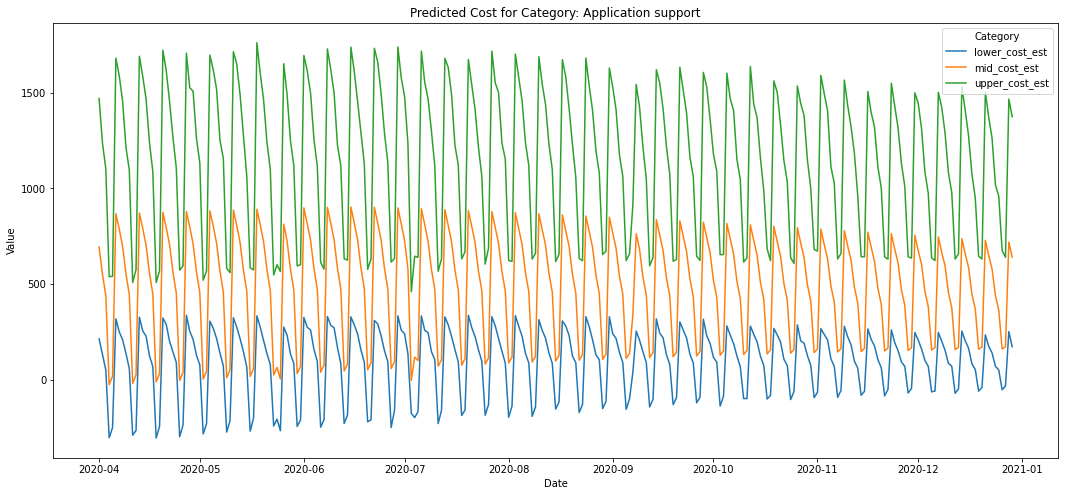

In [464]:
#GET STAFFING SCHEDULE
application_support_j_staffing = get_staffing(a_fbdn, a_fcount, categories_j[3])
application_support_j_cost = get_cost(application_support_j_staffing, categories_j[3])
application_support_j_staffing

## J_DATA: INFRASTRUCTURE SERVICES

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


----------------------------------------------------------------------------------------
TICKET count FORECAST FOR CATEGORY: Infrastructure services
----------------------------------------------------------------------------------------
FORECAST TABLE:
            ds      yhat  yhat_lower  yhat_upper
268 2020-12-25  5.757599    1.006475   10.442907
269 2020-12-26  2.976581   -1.810762    7.482074
270 2020-12-27  3.127209   -1.422305    7.755333
271 2020-12-28  6.041843    1.462940   10.946234
272 2020-12-29  6.699573    1.836246   11.042803
----------------------------------------------------------------------------------------


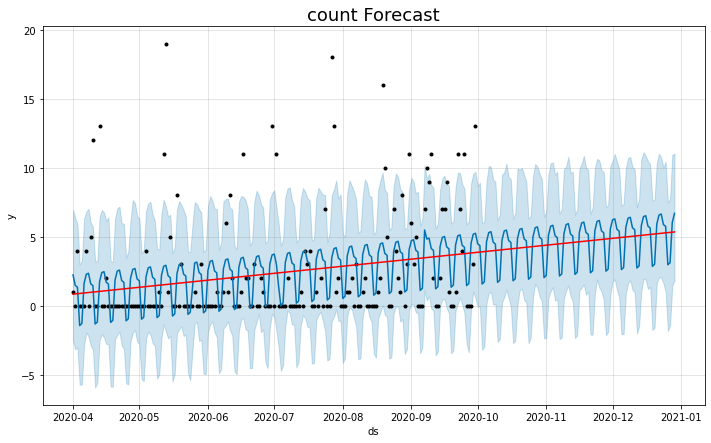

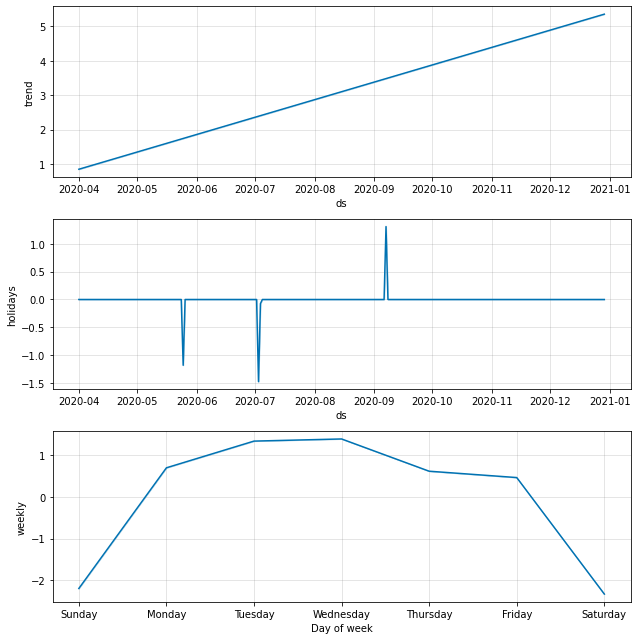

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


.
.
.
.
.
.
.
.
.
.
----------------------------------------------------------------------------------------
TICKET adj_bdn FORECAST FOR CATEGORY: Infrastructure services
----------------------------------------------------------------------------------------
FORECAST TABLE:
            ds           yhat     yhat_lower     yhat_upper
268 2020-12-25   71382.730128   16765.766861  130069.747290
269 2020-12-26 -153914.491537 -209243.296819  -93754.221073
270 2020-12-27   58639.055504    2966.490396  113702.526542
271 2020-12-28   97832.087200   45029.179787  150209.278613
272 2020-12-29   83485.589741   28424.677509  139406.738188
----------------------------------------------------------------------------------------


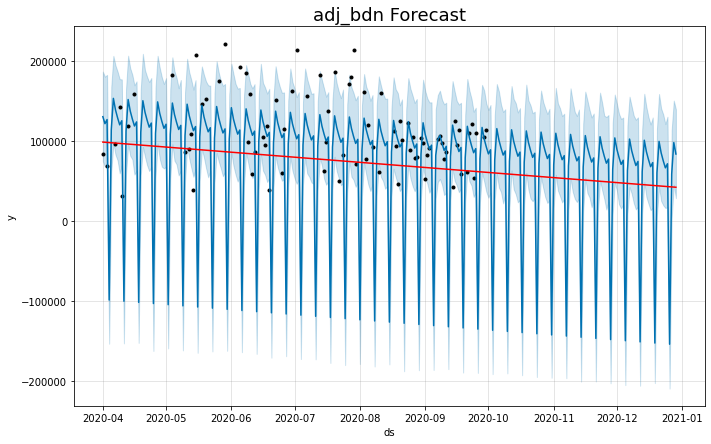

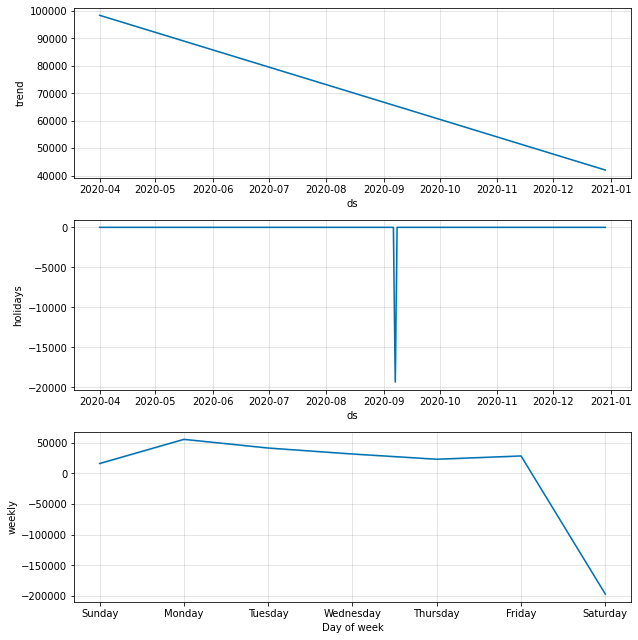

In [465]:
#GET FORECASTS
a_fcount = get_forecast(infrastructure_j, 'count', categories_j[4])
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
a_fbdn = get_forecast(infrastructure_j, 'adj_bdn', categories_j[4])

In [466]:
#remove 0s from DFs
a_fcount = negative_to_zero_transform(a_fcount)
a_fbdn = negative_to_zero_transform(a_fbdn)


date  lower_est        est  upper_est
0   2020-04-01  -6.568096  10.137569  44.974699
1   2020-04-02  -7.375246   6.262097  39.916580
2   2020-04-03  -7.588614   5.929525  37.498956
3   2020-04-04  30.398767   4.908983  -4.639582
4   2020-04-05 -12.128951  -5.059226  18.793207
..         ...        ...        ...        ...
268 2020-12-25   0.585914  14.270596  47.163414
269 2020-12-26  13.155900 -15.907602 -24.356807
270 2020-12-27  -0.146502   6.367242  30.618089
271 2020-12-28   2.287326  20.523823  57.091176
272 2020-12-29   1.812316  19.420758  53.452820

[273 rows x 4 columns]

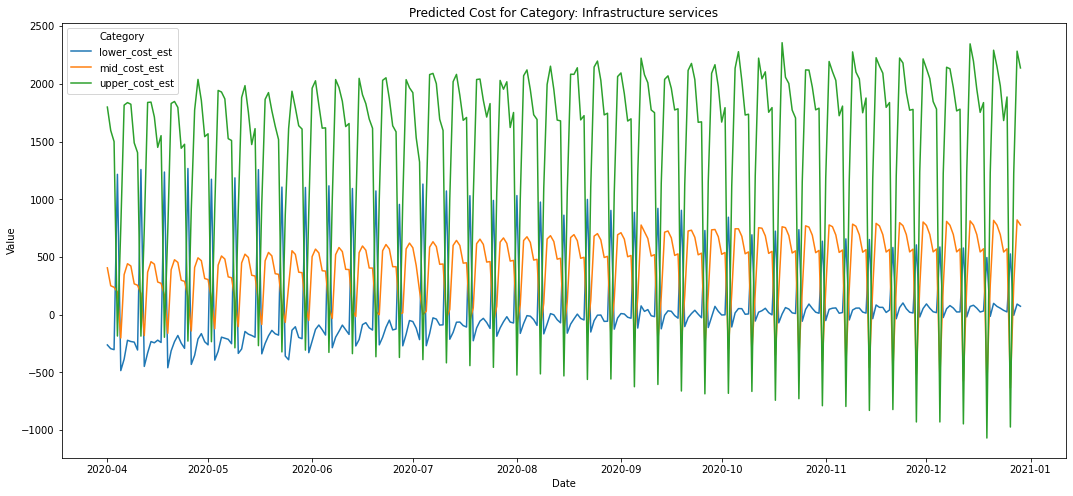

In [467]:
#GET STAFFING SCHEDULE
infrastructure_j_staffing = get_staffing(a_fbdn, a_fcount, categories_j[4])
infrastructure_j_cost = get_cost(infrastructure_j_staffing, categories_j[4])
infrastructure_j_staffing


## J_DATA: EASY CONNECT

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


----------------------------------------------------------------------------------------
TICKET count FORECAST FOR CATEGORY: Easy connect
----------------------------------------------------------------------------------------
FORECAST TABLE:
            ds      yhat  yhat_lower  yhat_upper
268 2020-12-25  2.278510    0.276410    4.091013
269 2020-12-26  1.618299   -0.379890    3.447967
270 2020-12-27  1.845136   -0.064911    3.846179
271 2020-12-28  3.445587    1.645260    5.371722
272 2020-12-29  3.873794    2.077216    5.823771
----------------------------------------------------------------------------------------


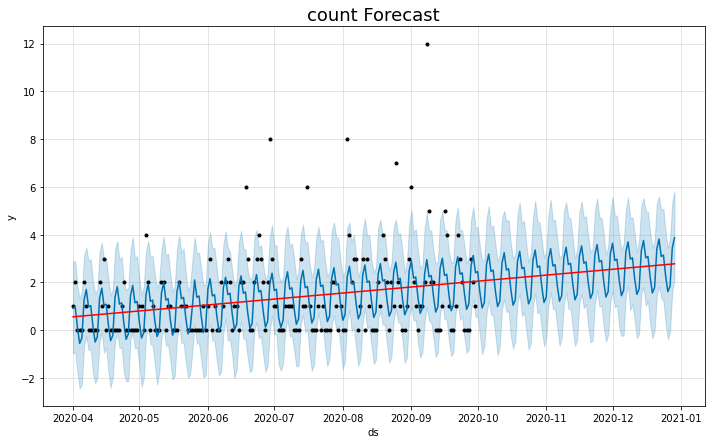

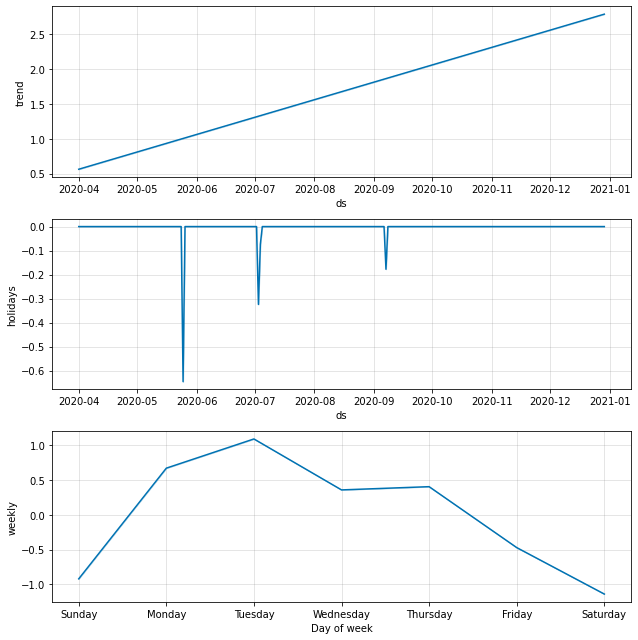

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


.
.
.
.
.
.
.
.
.
.
----------------------------------------------------------------------------------------
TICKET adj_bdn FORECAST FOR CATEGORY: Easy connect
----------------------------------------------------------------------------------------
FORECAST TABLE:
            ds          yhat    yhat_lower     yhat_upper
268 2020-12-25  28445.766027  -8735.047427   65700.815303
269 2020-12-26  73561.890022  37899.712814  109714.765300
270 2020-12-27  49224.366268  15025.141935   83416.593799
271 2020-12-28  49555.704853  13184.055581   85665.242602
272 2020-12-29  48922.417505  14067.911628   81915.848777
----------------------------------------------------------------------------------------


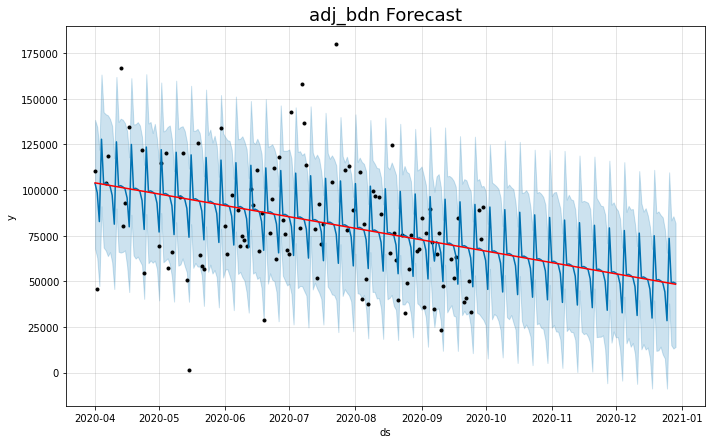

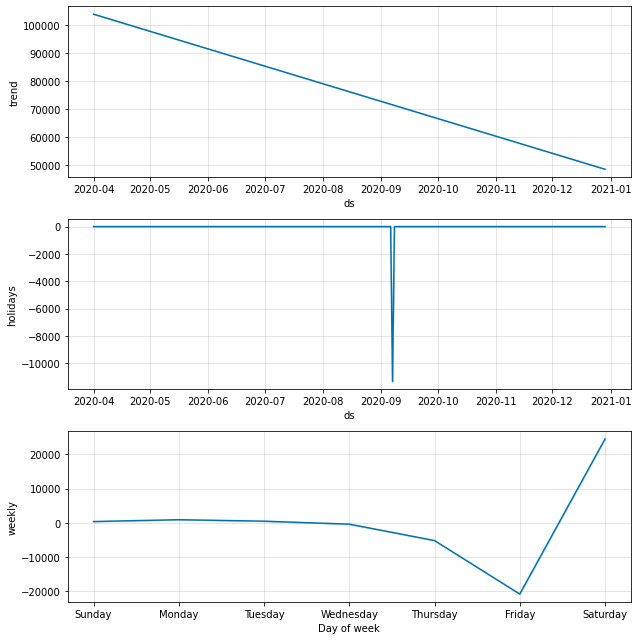

In [468]:
#GET FORECASTS
a_fcount = get_forecast(easy_connect_j, 'count', categories_j[5])
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
a_fbdn = get_forecast(easy_connect_j, 'adj_bdn', categories_j[5])

In [469]:
#remove 0s from DFs
a_fcount = negative_to_zero_transform(a_fcount)
a_fbdn = negative_to_zero_transform(a_fbdn)


date  lower_est       est  upper_est
0   2020-04-01  -2.266129  3.318991  13.909776
1   2020-04-02  -2.036010  3.346070  13.474077
2   2020-04-03  -2.920279  0.314390   7.790217
3   2020-04-04  -7.719894 -2.445123   7.600672
4   2020-04-05  -5.371843 -1.164358   7.916931
..         ...        ...       ...        ...
268 2020-12-25  -0.083835  2.250485   9.332740
269 2020-12-26  -0.499921  4.133512  13.135171
270 2020-12-27  -0.033864  3.153668  11.140110
271 2020-12-28   0.753167  5.928768  15.978121
272 2020-12-29   1.014656  6.580394  16.564554

[273 rows x 4 columns]

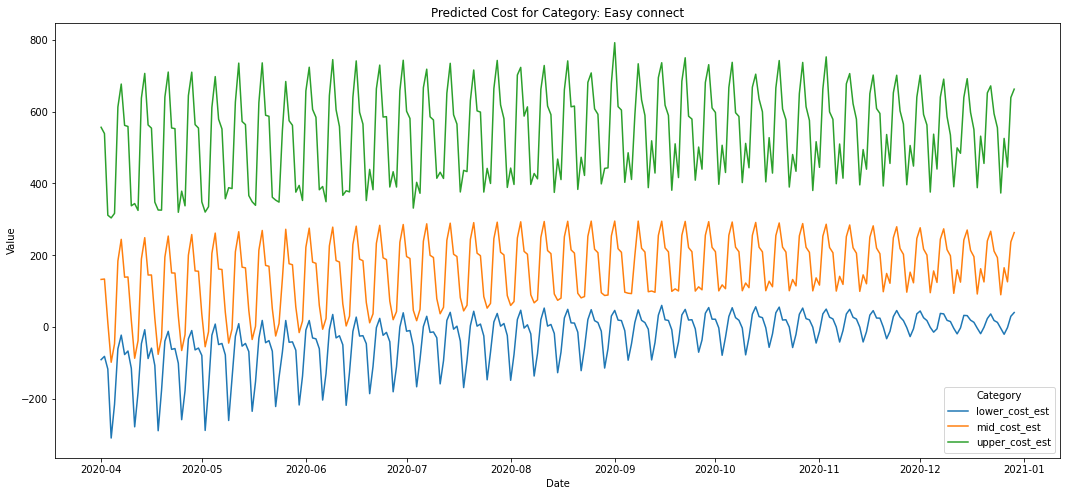

In [470]:
#GET STAFFING SCHEDULE
easy_connect_j_staffing = get_staffing(a_fbdn, a_fcount, categories_j[5])
easy_connect_j_cost = get_cost(easy_connect_j_staffing, categories_j[5])
easy_connect_j_staffing


## J_DATA: TELEPHONE & CONFERENCE

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


----------------------------------------------------------------------------------------
TICKET count FORECAST FOR CATEGORY: Telephone & Conference (Audio, Video)
----------------------------------------------------------------------------------------
FORECAST TABLE:
            ds      yhat  yhat_lower  yhat_upper
268 2020-12-25  0.011952   -0.243071    0.285594
269 2020-12-26  0.011972   -0.264695    0.295227
270 2020-12-27  0.050347   -0.231535    0.317368
271 2020-12-28  0.127254   -0.177982    0.378289
272 2020-12-29  0.050391   -0.237340    0.324675
----------------------------------------------------------------------------------------


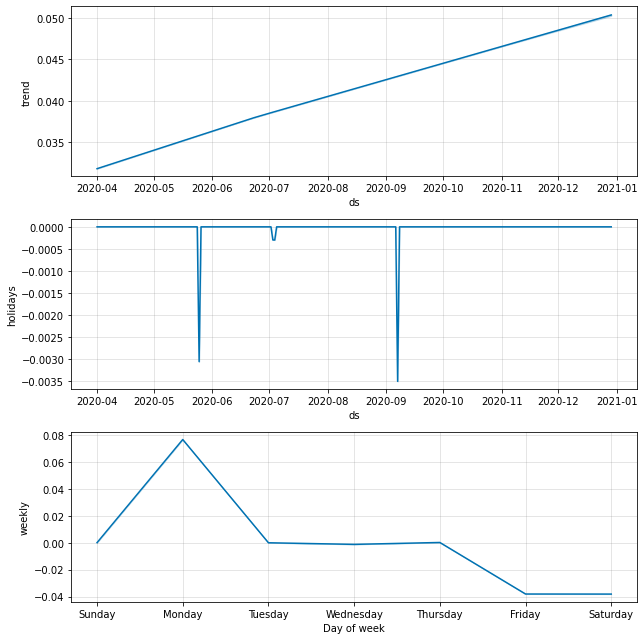

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


.
.
.
.
.
.
.
.
.
.
----------------------------------------------------------------------------------------
TICKET adj_bdn FORECAST FOR CATEGORY: Telephone & Conference (Audio, Video)
----------------------------------------------------------------------------------------
FORECAST TABLE:
            ds          yhat    yhat_lower    yhat_upper
268 2020-12-25 -2.915706e+06 -2.994626e+06 -2.835601e+06
269 2020-12-26  2.013030e+06  1.933451e+06  2.095557e+06
270 2020-12-27  2.925075e+05  2.122583e+05  3.766091e+05
271 2020-12-28  5.729539e+05  4.919374e+05  6.587548e+05
272 2020-12-29  5.484831e+05  4.666851e+05  6.361885e+05
----------------------------------------------------------------------------------------


In [471]:
#GET FORECASTS
a_fcount = get_forecast(tele_conference_j, 'count', categories_j[6])
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
print('.')
a_fbdn = get_forecast(tele_conference_j, 'adj_bdn', categories_j[6])

In [472]:
#remove 0s from DFs
a_fcount = negative_to_zero_transform(a_fcount)
a_fbdn = negative_to_zero_transform(a_fbdn)


date  lower_est       est  upper_est
0   2020-04-01  -0.980263  0.117575   1.216346
1   2020-04-02   0.615408 -0.079235  -0.799604
2   2020-04-03  31.128514  0.728716 -32.993066
3   2020-04-04 -14.308374 -0.319680  13.873560
4   2020-04-05   1.769624 -0.240963  -2.366488
..         ...        ...       ...        ...
268 2020-12-25  25.274516 -1.209978 -28.119093
269 2020-12-26 -17.769962  0.836805  21.481437
270 2020-12-27  -1.706435  0.511351   4.150124
271 2020-12-28  -3.040138  2.531613   8.652760
272 2020-12-29  -3.845932  0.959676   7.172036

[273 rows x 4 columns]

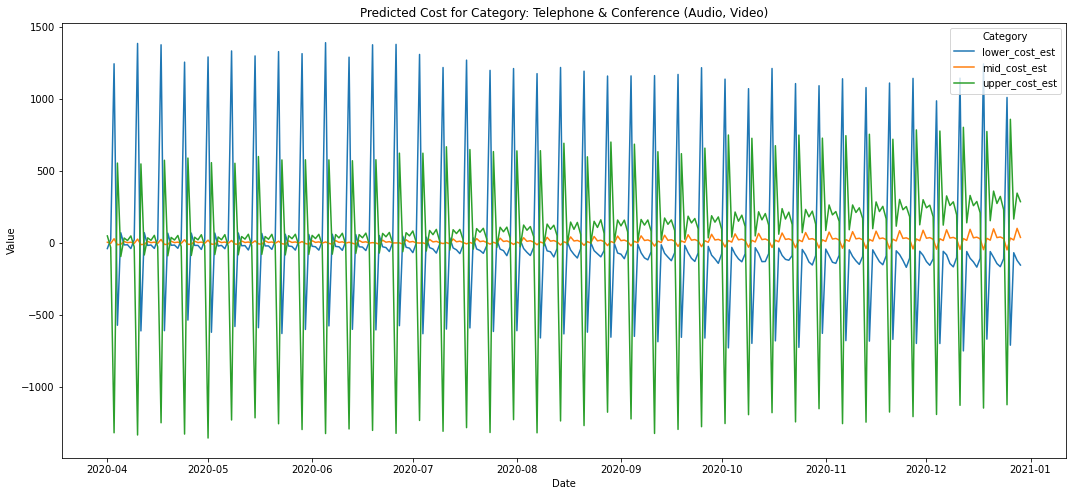

In [473]:
#GET STAFFING SCHEDULE
tele_conference_j_staffing = get_staffing(a_fbdn, a_fcount, categories_j[6])
tele_conference_j_cost = get_cost(tele_conference_j_staffing, categories_j[6])
tele_conference_j_staffing


# COMPILING COST RESULTS

The Labor Cost for COMPANY A during December 2020
is estimated to be $56756.66.


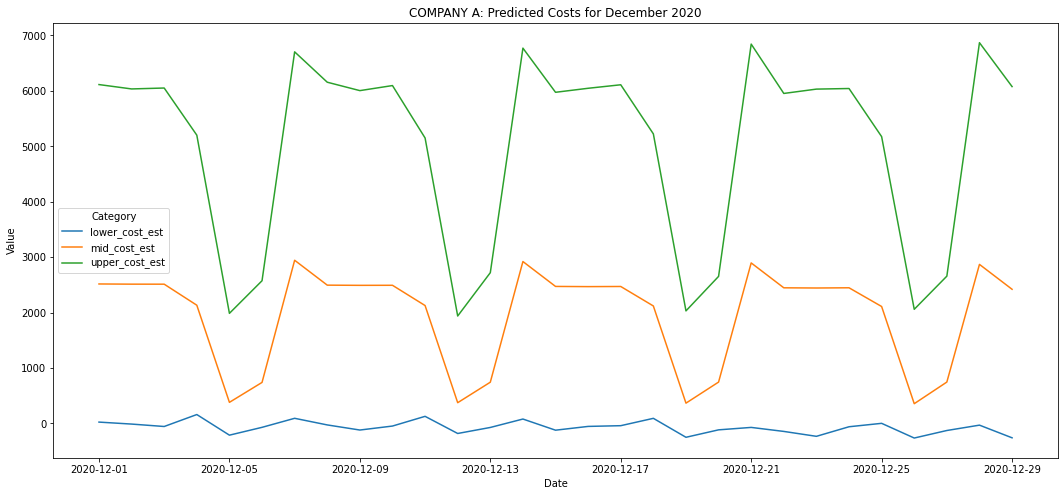

In [474]:
#COMPANY A

cost_a = pd.DataFrame()
cost_a['date'] = access_a_cost['date']
cost_a['lower_cost_est'] = access_a_cost['lower_cost_est'] + software_a_cost['lower_cost_est'] + application_a_cost['lower_cost_est'] + general_a_cost['lower_cost_est'] + email_a_cost['lower_cost_est'] + hardware_a_cost['lower_cost_est']
cost_a['mid_cost_est'] = access_a_cost['mid_cost_est'] + software_a_cost['mid_cost_est'] + application_a_cost['mid_cost_est'] + general_a_cost['mid_cost_est'] + email_a_cost['mid_cost_est'] + hardware_a_cost['mid_cost_est']
cost_a['upper_cost_est'] = access_a_cost['upper_cost_est'] + software_a_cost['upper_cost_est'] + application_a_cost['upper_cost_est'] + general_a_cost['upper_cost_est'] + email_a_cost['upper_cost_est'] + hardware_a_cost['upper_cost_est']

cost_a

cost_a = cost_a.set_index('date') #set index as date for subsetting
  
#Get JUST December
cost_a_dec = cost_a['2020-12-01':]
cost_a_dec.reset_index(inplace=True)
cost_a_dec

#Transform to Long Form
cost_a_dec = cost_a_dec.set_index('date')
cost_a_dec_lf = cost_a_dec.unstack().reset_index()
cost_a_dec_lf.columns = ['Category', 'Date', 'Value']
cost_a_dec_lf = cost_a_dec_lf[['Date', 'Value', 'Category']]
cost_a_dec_lf

#Plot Data
fig, ax = plt.subplots(figsize=(18,8))
sns.lineplot(ax=ax, data=cost_a_dec_lf, x='Date', y='Value', hue='Category', err_style="bars", ci=68).set_title('COMPANY A: Predicted Costs for December 2020')


print('The Labor Cost for COMPANY A during December 2020')
print('is estimated to be ${:.2f}.'.format(cost_a_dec['mid_cost_est'].sum()))


The Labor Cost for COMPANY J during December 2020
is estimated to be $32610.57.


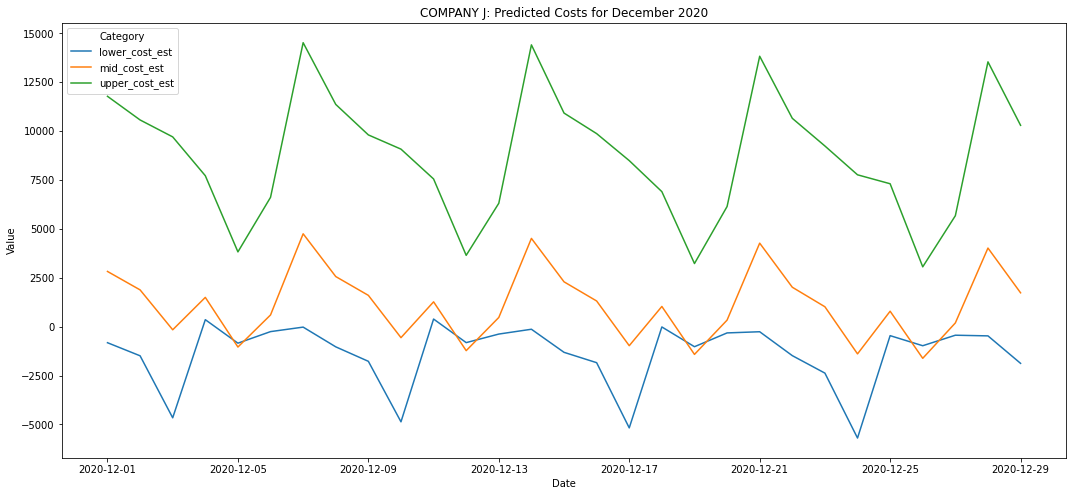

In [475]:
#COMPANY J

cost_j = pd.DataFrame()
cost_j['date'] = task_j_cost['date']
cost_j['lower_cost_est'] = task_j_cost['lower_cost_est'] + desktop_laptop_j_cost['lower_cost_est'] + access_pw_j_cost['lower_cost_est'] + application_support_j_cost['lower_cost_est'] + infrastructure_j_cost['lower_cost_est'] + easy_connect_j_cost['lower_cost_est'] + tele_conference_j_cost['lower_cost_est']
cost_j['mid_cost_est'] = task_j_cost['mid_cost_est'] + desktop_laptop_j_cost['mid_cost_est'] + access_pw_j_cost['mid_cost_est'] + application_support_j_cost['mid_cost_est'] + infrastructure_j_cost['mid_cost_est'] + easy_connect_j_cost['mid_cost_est'] + tele_conference_j_cost['mid_cost_est']
cost_j['upper_cost_est'] = task_j_cost['upper_cost_est'] + desktop_laptop_j_cost['upper_cost_est'] + access_pw_j_cost['upper_cost_est'] + application_support_j_cost['upper_cost_est'] + infrastructure_j_cost['upper_cost_est'] + easy_connect_j_cost['upper_cost_est'] + tele_conference_j_cost['upper_cost_est']

cost_j

cost_j = cost_j.set_index('date') #set index as date for subsetting
  
#Get JUST December
cost_j_dec = cost_j['2020-12-01':]
cost_j_dec.reset_index(inplace=True)
cost_j_dec

#Transform to Long Form
cost_j_dec = cost_j_dec.set_index('date')
cost_j_dec_lf = cost_j_dec.unstack().reset_index()
cost_j_dec_lf.columns = ['Category', 'Date', 'Value']
cost_j_dec_lf = cost_j_dec_lf[['Date', 'Value', 'Category']]
cost_j_dec_lf

#Plot Data
fig, ax = plt.subplots(figsize=(18,8))
sns.lineplot(ax=ax, data=cost_j_dec_lf, x='Date', y='Value', hue='Category', err_style="bars", ci=68).set_title('COMPANY J: Predicted Costs for December 2020')


print('The Labor Cost for COMPANY J during December 2020')
print('is estimated to be ${:.2f}.'.format(cost_j_dec['mid_cost_est'].sum()))


In [476]:
print('Company J: Task')
print(task_j_cost['mid_cost_est'].sum())
print(task_j_cost['lower_cost_est'].sum())
print('.')
print('.')
print('.')
print('Company J:Desktop Laptop')
print(desktop_laptop_j_cost['mid_cost_est'].sum())
print(desktop_laptop_j_cost['lower_cost_est'].sum())
print('.')
print('.')
print('.')
print('Company J: Access PW')
print(access_pw_j_cost['mid_cost_est'].sum())
print(access_pw_j_cost['lower_cost_est'].sum())
print('.')
print('.')
print('.')
print('Company J: Application')
print(application_support_j_cost['mid_cost_est'].sum())
print(application_support_j_cost['lower_cost_est'].sum())
print('.')
print('.')
print('.')
print('Company J: Infrastructure')
print(infrastructure_j_cost['mid_cost_est'].sum())
print(infrastructure_j_cost['lower_cost_est'].sum())
print('.')
print('.')
print('.')
print('Company J: Easy Connect')
print(easy_connect_j_cost['mid_cost_est'].sum())
print(easy_connect_j_cost['lower_cost_est'].sum())
print('.')
print('.')
print('.')
print('Company J: TeleConference')
print(tele_conference_j_cost['mid_cost_est'].sum())
print(tele_conference_j_cost['lower_cost_est'].sum())

Company J: Task
338994.8199025123
-150178.94741749717
.
.
.
Company J:Desktop Laptop
225966.8929086373
84129.39871287171
.
.
.
Company J: Access PW
163856.01620479918
16930.656811494602
.
.
.
Company J: Application
132929.6604741876
24642.796189475564
.
.
.
Company J: Infrastructure
106178.77746890135
15396.990844596934
.
.
.
Company J: Easy Connect
43148.43839391014
-8308.452179481546
.
.
.
Company J: TeleConference
3333.8540771061807
12309.379573954862


In [477]:
print('Company A: Access')
print(access_a_cost['mid_cost_est'].sum())
print(access_a_cost['lower_cost_est'].sum())
print('.')
print('.')
print('.')
print('Company A: Software')
print(software_a_cost['mid_cost_est'].sum())
print(software_a_cost['lower_cost_est'].sum())
print('.')
print('.')
print('.')
print('Company A: Application')
print(application_a_cost['mid_cost_est'].sum())
print(application_a_cost['lower_cost_est'].sum())
print('.')
print('.')
print('.')
print('Company A: General')
print(general_a_cost['mid_cost_est'].sum())
print(general_a_cost['lower_cost_est'].sum())
print('.')
print('.')
print('.')
print('Company A: Email')
print(email_a_cost['mid_cost_est'].sum())
print(email_a_cost['lower_cost_est'].sum())
print('.')
print('.')
print('.')
print('Company A: Computer Hardware')
print(hardware_a_cost['mid_cost_est'].sum())
print(hardware_a_cost['lower_cost_est'].sum())


Company A: Access
233818.62057021447
72539.21314989828
.
.
.
Company A: Software
125096.75358053812
39215.4486650854
.
.
.
Company A: Application
78615.83631766704
17.43863694303809
.
.
.
Company A: General
11780.807201082744
-18100.044033995626
.
.
.
Company A: Email
29004.261394890556
-6049.801963412253
.
.
.
Company A: Computer Hardware
62948.00143722194
1911.3650348303354
